In [66]:
import importlib
import volpy_func_lib as vp
import load_clean_lib
import table_lib
import vol_strat_lib as vs
import option_returns as orpy
from global_settings import *
import pandas as pd
import numpy as np
import cor_lib

importlib.reload(vp)
importlib.reload(load_clean_lib)
importlib.reload(table_lib)
importlib.reload(vs)
importlib.reload(orpy)
importlib.reload(cor_lib)

<module 'cor_lib' from 'c:\\Users\\axell\\Desktop\\CBS\\master\\volpy\\cor_lib.py'>

### import orpy and sum

In [39]:
# df_orpy = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short\t_df_orpy.csv")
# df_orpy["date"] = pd.to_datetime(df_orpy["date"])

sum_df = pd.read_csv(r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_summary_dly.csv")
sum_df["date"] = pd.to_datetime(sum_df["date"])
sum_df[f"return_next"] = sum_df[f"return"].shift(-1)

### import crsp data, constituents and map constituents to crsp data and select constituents

In [400]:
importlib.reload(cor_lib)
constituents_long, daily_returns_constituents = cor_lib.get_index_constituents_and_returns("INDU")

Fil fundet: C:\Users\axell\Desktop\CBS\data\OptionMetrics\Tickers\cor metadata\daily_returns_indu.csv – skipper beregning og loader fil i stedet.


### number of constituents with data over time 

Mindste antal aktiver på en dag: 22


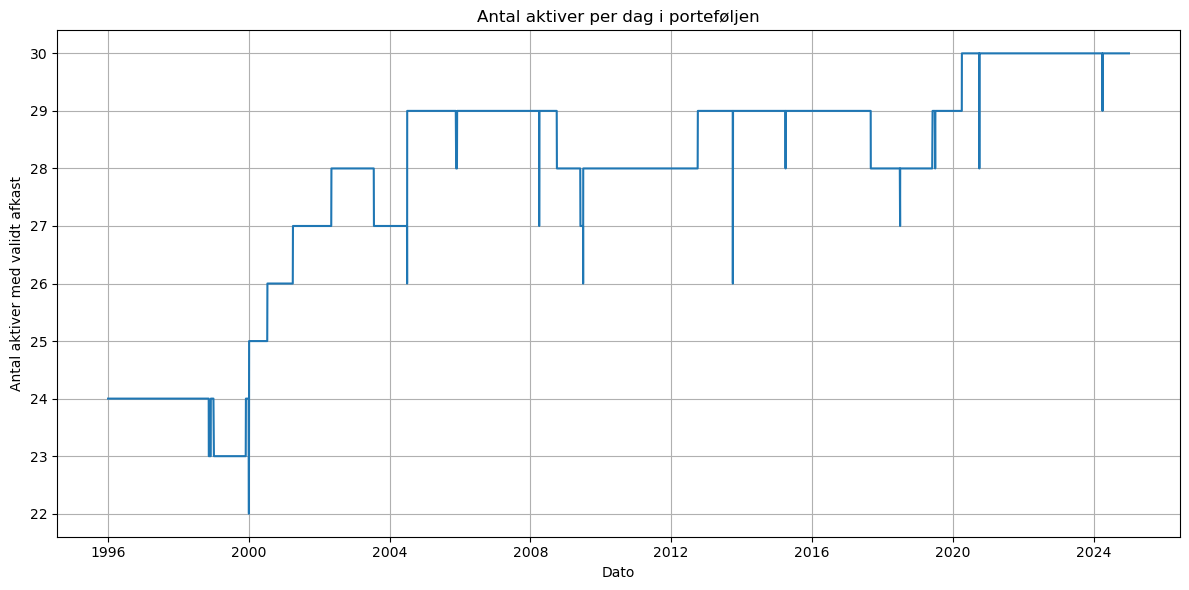

In [401]:
import matplotlib.pyplot as plt

# Tæl antal aktiver (ikke-NaN returns) per dag
assets_per_day = daily_returns_constituents.groupby("date")["return"].count()

# Udskriv mindste antal aktiver
print(f"Mindste antal aktiver på en dag: {assets_per_day.min()}")

# Plot antal aktiver over tid
plt.figure(figsize=(12,6))
plt.plot(assets_per_day.index, assets_per_day.values)
plt.xlabel("Dato")
plt.ylabel("Antal aktiver med validt afkast")
plt.title("Antal aktiver per dag i porteføljen")
plt.grid(True)
plt.tight_layout()
plt.show()


### calculate index returns

In [402]:
importlib.reload(cor_lib)
replicated_returns_daily = cor_lib.get_replicated_index_returns(daily_returns_constituents)

### get true index returns from index data (bloom) and merge to complete df

In [403]:
importlib.reload(cor_lib)
index_daily_returns_df = cor_lib.add_return_true(replicated_returns_daily, ticker = "INDU")

In [404]:
import pandas as pd
import numpy as np

def decompose_variance_flexible_weights(
    df,
    window: int = 30,
    average_weights: bool = True,
    rho_mean_method: str = "equal",
    min_pct: float = 0.8
):
    """
    Dekomponér den rullede portefølje-varians i variance- og covariance-delen
    med fleksible vægte.  
    - df: DataFrame med kolonner ['date','ticker','return','weight']  
    - window: rullevindue i dage  
    - average_weights: True -> gennemsnitsvægte, False -> vægte fra sidste dag  
    - rho_mean_method: 'equal' eller 'weighted' til beregning af rho_mean  
    - min_pct: minimum % af dage en ticker skal have retur-data i vinduet  
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    # Pivot, behold NaN (vi ikke imputerer her)
    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight")

    out = []
    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]
        r_win = R.loc[win]
        w_win = W.loc[win]

        # 1) Filtrér tickers efter min_pct dage med data
        req = int(np.ceil(window * min_pct))
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid]
        w_sel = w_win[valid]

        # 2) Vælg vægte
        w_ts = w_sel.mean(axis=0) if average_weights else w_sel.iloc[-1]

        # 3) Beregn sigma og corr (kun på de dage der ER data)
        #    (NaNs i r_sel ignoreres i std()/corr())
        sigma = r_sel.std()
        corr  = r_sel.corr().fillna(0)

        # 4) Trim til tickers med sigma>0
        ok = sigma.index[sigma > 0]
        if len(ok) < 2:
            continue

        w_vec = w_ts[ok].values
        s_vec = sigma[ok].values
        C     = corr.loc[ok, ok].values

        # 5) Variance vs covariance
        ws = w_vec * s_vec
        var_diag    = np.sum((w_vec**2) * (s_vec**2))
        var_offdiag = np.sum(np.outer(ws, ws) * C) - np.sum(ws**2)
        var_tot     = var_diag + var_offdiag

        # 6) rho_mean
        if rho_mean_method == "equal":
            mask    = ~np.eye(len(ok), dtype=bool)
            rho_mean = C[mask].mean()
        else:  # weighted
            rho_sum  = np.sum(np.outer(w_vec, w_vec) * C) - np.sum(w_vec**2)
            rho_mean = rho_sum / (1 - np.sum(w_vec**2))

        out.append({
            "date":                    dt,
            "vol_variance_component":   np.sqrt(var_diag    * 252),
            "vol_covariance_component": np.sqrt(var_offdiag * 252),
            "vol_total_reconstructed":  np.sqrt(var_tot     * 252),
            "rho_mean":                 rho_mean,
            "n_assets_used":            len(ok),
            "n_days_used":              window
        })

    return pd.DataFrame(out)


def add_all_variance_components(
    index_df,
    constituents_df,
    window: int = 30,
    average_weights: bool = True,
    rho_mean_method: str = "equal",
    min_pct: float = 0.8
):
    """
    Læg vol_rolling_true, vol_rolling_replicated og alle variance-komponenter sammen.
    """
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])

    # Rullende volatility
    idx["vol_rolling_true"]       = idx["return_true"].rolling(window).std()*np.sqrt(252)
    idx["vol_rolling_replicated"] = idx["return_replicated"].rolling(window).std()*np.sqrt(252)

    # Dekomponering
    var_corr_df = decompose_variance_flexible_weights(
        constituents_df,
        window=window,
        average_weights=average_weights,
        rho_mean_method=rho_mean_method,
        min_pct=min_pct
    )
    var_corr_df["date"] = pd.to_datetime(var_corr_df["date"])

    # Merge på date
    merged = idx.merge(var_corr_df, on="date", how="left")
    return merged


index_df = add_all_variance_components(
    index_daily_returns_df,
    daily_returns_constituents,
    window=21*3,
    average_weights=False,
    rho_mean_method="equal",
    min_pct=0.9
)



In [375]:

def decompose_variance_flexible_weights(
    df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    rho_mean_method: str = "equal",
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Dekomponér rullede variance- og covariance-komponenter vha. fleksible vægte.

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight"]
    - window: rullevindue (dage)
    - average_weights: True -> gennemsnitsvægte, False -> vægte fra sidste dag
    - rho_mean_method: 'equal' eller 'weighted'
    - min_pct: minimum % af dage en ticker skal have retur i vinduet
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight")

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]

        n_days = len(r_sel)
        if n_days < 2:
            continue

        w_ts = w_sel.mean(axis=0) if average_weights else w_sel.iloc[-1]

        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()  # .fillna(0)

        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv = w_ts[ok].values
        sv = sigma_t[ok].values
        Cv = corr_t.loc[ok,ok].values

        ws = wv * sv
        var_diag    = np.sum((wv**2) * (sv**2))
        var_offdiag = np.sum(np.outer(ws, ws) * Cv) - np.sum(ws**2)
        var_tot     = var_diag + var_offdiag

        if rho_mean_method == "equal":
            mask     = ~np.eye(len(ok), dtype=bool)
            rho_mean = Cv[mask].mean()
        else:
            rho_sum  = np.sum(np.outer(wv, wv) * Cv) - np.sum(wv**2)
            rho_mean = rho_sum / (1 - np.sum(wv**2))

        out.append({
            "date":                     dt,
            "vol_variance_component":   np.sqrt(var_diag    * 252),
            "vol_covariance_component": np.sqrt(var_offdiag * 252),
            "vol_total_reconstructed":  np.sqrt(var_tot     * 252),
            "rho_mean":                 rho_mean,
            "n_assets_used":            len(ok),
            "n_days_used":              n_days
        })

    return pd.DataFrame(out)


def add_all_variance_components(
    index_df: pd.DataFrame,
    constituents_df: pd.DataFrame,
    window: int = 30,
    average_weights: bool = True,
    rho_mean_method: str = "equal",
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Tilføj alle volatility‐kolonner til index_df:
      - vol_rolling_true
      - vol_rolling_replicated
      - vol_variance_component
      - vol_covariance_component
      - vol_total_reconstructed
      - rho_mean
      - n_assets_used
      - n_days_used
    """
    idx = index_df.copy()
    idx["date"] = pd.to_datetime(idx["date"])
    idx["vol_rolling_true"]       = idx["return_true"].rolling(window).std(ddof=0)       * np.sqrt(252)
    idx["vol_rolling_replicated"] = idx["return_replicated"].rolling(window).std(ddof=0) * np.sqrt(252)

    var_corr_df = decompose_variance_flexible_weights(
        constituents_df,
        window=window,
        average_weights=average_weights,
        rho_mean_method=rho_mean_method,
        min_pct=min_pct
    )
    var_corr_df["date"] = pd.to_datetime(var_corr_df["date"])

    return idx.merge(var_corr_df, on="date", how="left")


# Eksempel på kørsel:
index_df = add_all_variance_components(
    index_daily_returns_df,
    daily_returns_constituents,
    window=21*3,
    average_weights=False,
    rho_mean_method="equal",
    min_pct=0.9
)

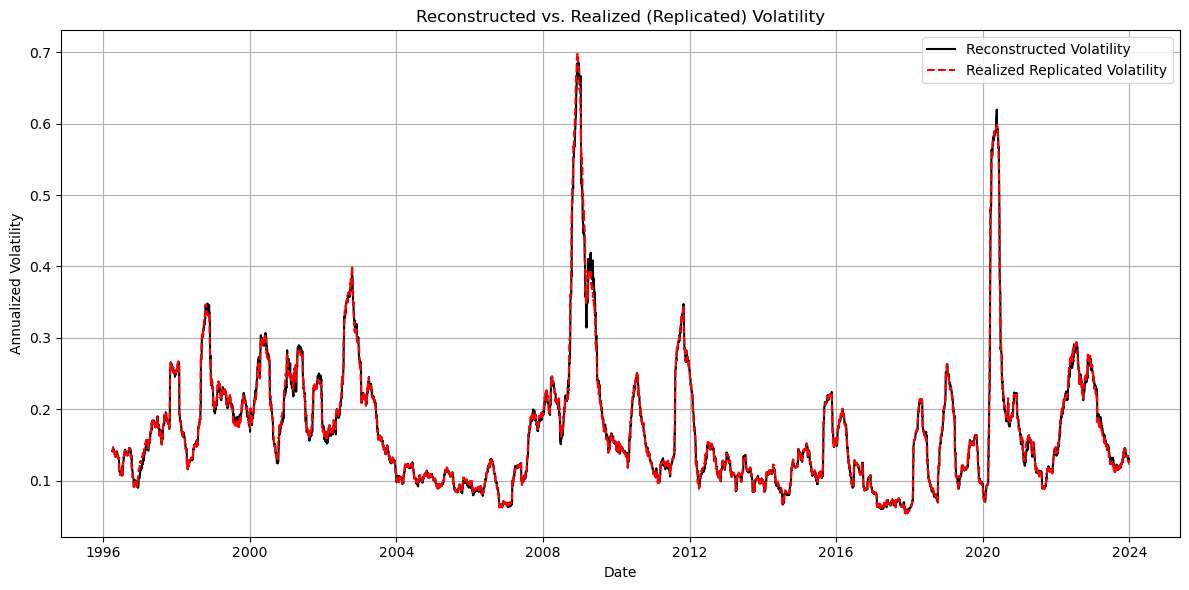

In [378]:
import matplotlib.pyplot as plt

def plot_reconstructed_vs_replicated_vol(df, start_date=None, end_date=None):
    # Filtrér datoer hvis angivet
    plot_df = df.copy()
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(plot_df["date"], plot_df["vol_total_reconstructed"], label="Reconstructed Volatility", color="black")
    plt.plot(plot_df["date"], plot_df["vol_rolling_replicated"], label="Realized Replicated Volatility", color="red", linestyle="--")
    
    plt.title("Reconstructed vs. Realized (Replicated) Volatility")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_reconstructed_vs_replicated_vol(index_df, start_date="1996-01-01", end_date="2023-12-31")


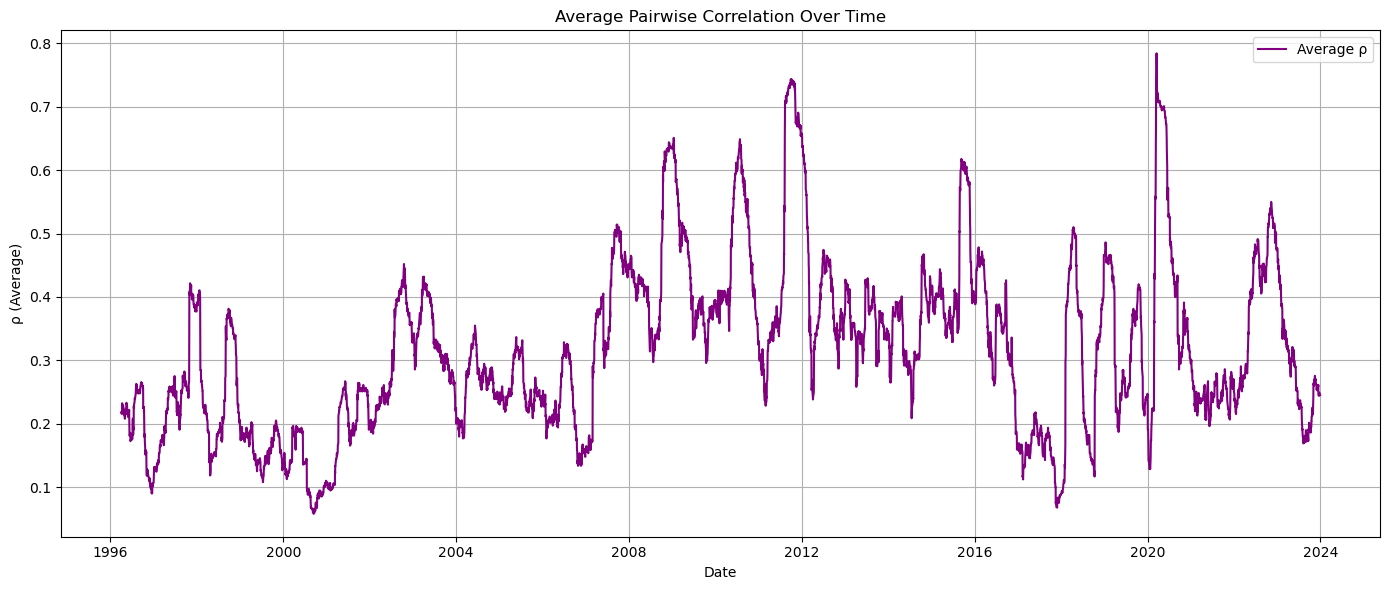

In [365]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rho_mean(df, start_date=None, end_date=None):
    """
    Plots the rolling average pairwise correlation (rho_mean) over time.
    
    Parametre:
    - df         : DataFrame med mindst kolonnerne ['date','rho_mean']
    - start_date : (valgfri) streng "YYYY-MM-DD" for plotstart
    - end_date   : (valgfri) streng "YYYY-MM-DD" for plotslut
    """
    plot_df = df.copy()
    plot_df["date"] = pd.to_datetime(plot_df["date"])
    
    if start_date:
        plot_df = plot_df[plot_df["date"] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df["date"] <= pd.to_datetime(end_date)]
    
    plt.figure(figsize=(14, 6))
    plt.plot(plot_df["date"], plot_df["rho_mean"], color="purple", label="Average ρ")
    plt.title("Average Pairwise Correlation Over Time")
    plt.xlabel("Date")
    plt.ylabel("ρ (Average)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Eksempel på kald:
plot_rho_mean(index_df, start_date="1996-01-01", end_date="2024-01-01")


In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def decompose_total_variance_fixed_elements(
    df: pd.DataFrame,
    window: int = 30,
    fix_to_constant: bool = False,
    min_pct: float = 0.8
) -> pd.DataFrame:
    """
    Dekomponér den samlede porteføljevariance og beregn:
      - vol_total_reconstructed
      - vol_total_fixed_sigma
      - vol_total_fixed_rho
      - n_assets_used
      - n_days_used

    Parametre:
    - df: DataFrame med ["date","ticker","return","weight"]
    - window: rullevindue (antal dage)
    - fix_to_constant: Hvis True, bruger konstante gennemsnits‐σ og ρ over hele perioden
    - min_pct: minimum % af dage en ticker skal have retur i vinduet
    """
    df = df.sort_values(["date", "ticker"])
    dates = df["date"].drop_duplicates().sort_values().to_list()

    R = df.pivot(index="date", columns="ticker", values="return")
    W = df.pivot(index="date", columns="ticker", values="weight")

    fixed_sigma = R.std(ddof=0)
    fixed_corr  = R.corr()

    if fix_to_constant:
        sigma_bar = fixed_sigma.mean()
        rho_bar   = fixed_corr.stack().mean()

    out = []
    req = int(np.ceil(window * min_pct))

    for i in range(window, len(dates)):
        dt  = dates[i]
        win = dates[i-window : i]

        r_win = R.loc[win]
        w_win = W.loc[win]

        # a) filtrér tickers på minimumsdækning
        valid = r_win.columns[r_win.notna().sum() >= req]
        if len(valid) < 2:
            continue

        r_sel = r_win[valid].dropna(axis=0)
        w_sel = w_win[valid].loc[r_sel.index]

        n_days = len(r_sel)
        if n_days < 2:
            continue

        # b) vægte fra sidste dag
        w_t = w_sel.iloc[-1]

        # c) beregn population std & corr på de rensede data
        sigma_t = r_sel.std(ddof=0)
        corr_t  = r_sel.corr()   # .fillna(0)

        ok = sigma_t.index[sigma_t > 0]
        if len(ok) < 2:
            continue

        wv  = w_t[ok].values
        sv  = sigma_t[ok].values
        Cv  = corr_t.loc[ok,ok].values
        fsv = fixed_sigma[ok].values
        fcv = fixed_corr.loc[ok,ok].values

        if fix_to_constant:
            fsv[:] = sigma_bar
            fcv[:] = rho_bar
            np.fill_diagonal(fcv, 1.0)

        cov_t    = np.outer(sv, sv) * Cv
        cov_fsig = np.outer(fsv, fsv) * Cv
        cov_frho = np.outer(sv, sv) * fcv

        var_act = wv @ (cov_t    @ wv)
        var_sig = wv @ (cov_fsig @ wv)
        var_rho = wv @ (cov_frho @ wv)

        out.append({
            "date":                   dt,
            "vol_total_reconstructed": np.sqrt(max(0, var_act * 252)),
            "vol_total_fixed_sigma":   np.sqrt(max(0, var_sig * 252)),
            "vol_total_fixed_rho":     np.sqrt(max(0, var_rho * 252)),
            "n_assets_used":           len(ok),
            "n_days_used":             n_days
        })

    return pd.DataFrame(out)

decomp_df = decompose_total_variance_fixed_elements(
    daily_returns_constituents,
    window=21*3,
    fix_to_constant=False,
    min_pct=0.9
)


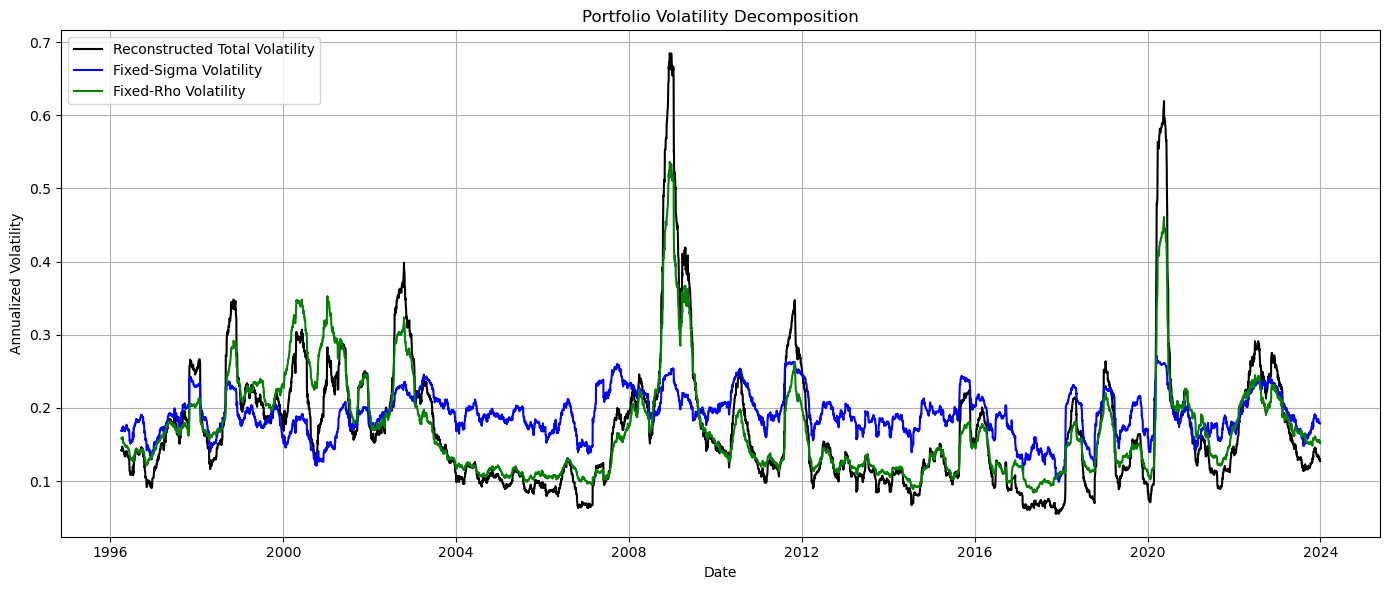

In [377]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_volatility_decomposition(
    df: pd.DataFrame,
    start_date: str = None,
    end_date:   str = None
):
    plot_df = df.copy()
    plot_df['date'] = pd.to_datetime(plot_df['date'])

    if start_date:
        plot_df = plot_df[plot_df['date'] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df['date'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(14, 6))
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_reconstructed'],
        label='Reconstructed Total Volatility',
        color='black'
    )
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_fixed_sigma'],
        label='Fixed‐Sigma Volatility',
        color='blue'
    )
    plt.plot(
        plot_df['date'],
        plot_df['vol_total_fixed_rho'],
        label='Fixed‐Rho Volatility',
        color='green'
    )

    plt.title('Portfolio Volatility Decomposition')
    plt.xlabel('Date')
    plt.ylabel('Annualized Volatility')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_volatility_decomposition(decomp_df, start_date="1996-01-01", end_date="2023-12-31")


In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_average_correlation(
    df: pd.DataFrame,
    window: int = 30,
    min_valid_fraction: float = 0.9
) -> pd.DataFrame:

    # Ensure sorted dates
    df = df.sort_values(['date', 'ticker'])
    all_dates = df['date'].drop_duplicates().sort_values().to_list()

    # Pivot to wide format
    returns_wide = df.pivot(index='date', columns='ticker', values='return')

    results = []
    # number of non-NaNs required per window
    min_obs = int(window * min_valid_fraction)

    for i in range(window, len(all_dates)):
        current_date = all_dates[i]
        window_dates = all_dates[i - window : i]
        window_data = returns_wide.loc[window_dates]

        # keep only tickers with enough data
        valid_tickers = window_data.columns[
            window_data.notna().sum() >= min_obs
        ]
        if len(valid_tickers) < 2:
            continue

        subset = window_data[valid_tickers]
        # drop any ticker that still has missing in-window
        subset = subset.dropna(axis=1)
        if subset.shape[1] < 2:
            continue

        # compute correlation matrix
        corr_mat = subset.corr()
        # extract upper triangle, excluding diagonal
        mask = np.triu(np.ones(corr_mat.shape), k=1).astype(bool)
        avg_corr = corr_mat.where(mask).stack().mean()

        results.append((current_date, avg_corr))

    return pd.DataFrame(results, columns=['date', 'average_correlation'])


# Example usage:
avg_corr_df = compute_average_correlation(
    daily_returns_constituents,
    window=21*12,
    min_valid_fraction=0.9
)


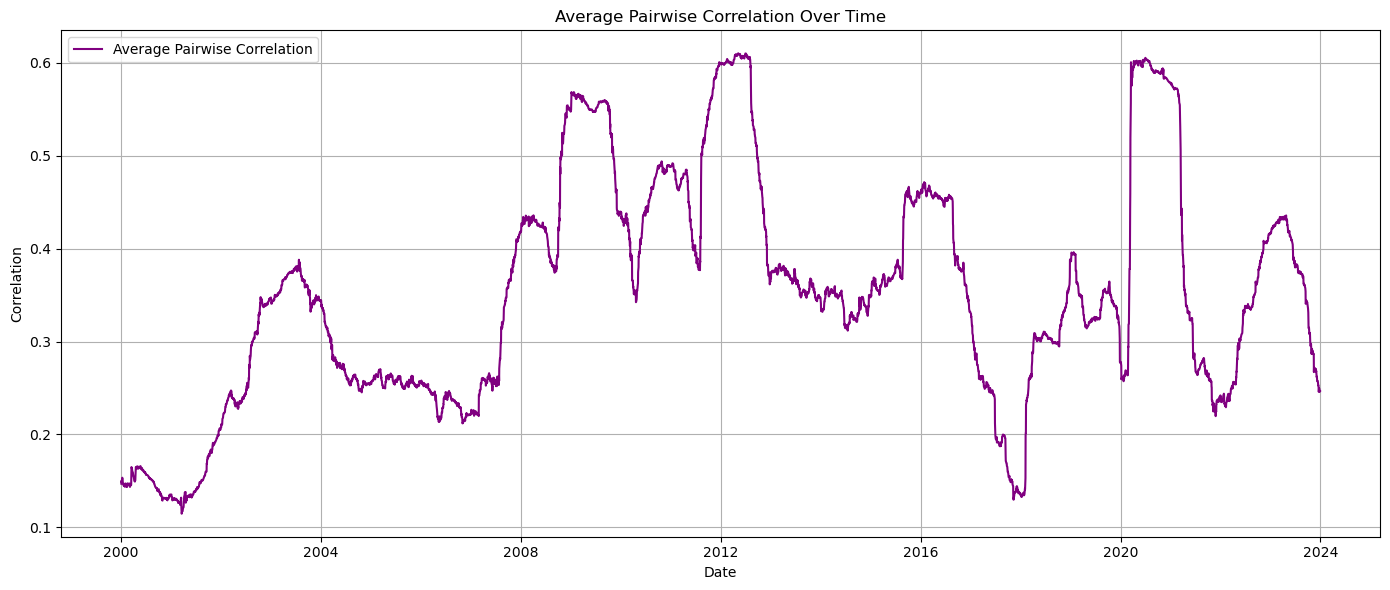

In [359]:

def plot_average_correlation(
    df: pd.DataFrame,
    start_date: str = None,
    end_date:   str = None
):

    plot_df = df.copy()
    plot_df['date'] = pd.to_datetime(plot_df['date'])
    if start_date:
        plot_df = plot_df[plot_df['date'] >= pd.to_datetime(start_date)]
    if end_date:
        plot_df = plot_df[plot_df['date'] <= pd.to_datetime(end_date)]

    plt.figure(figsize=(14, 6))
    plt.plot(
        plot_df['date'],
        plot_df['average_correlation'],
        color='purple',
        label='Average Pairwise Correlation'
    )
    plt.title('Average Pairwise Correlation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Correlation')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_average_correlation(avg_corr_df, start_date="2000-01-01", end_date="2024-01-01")


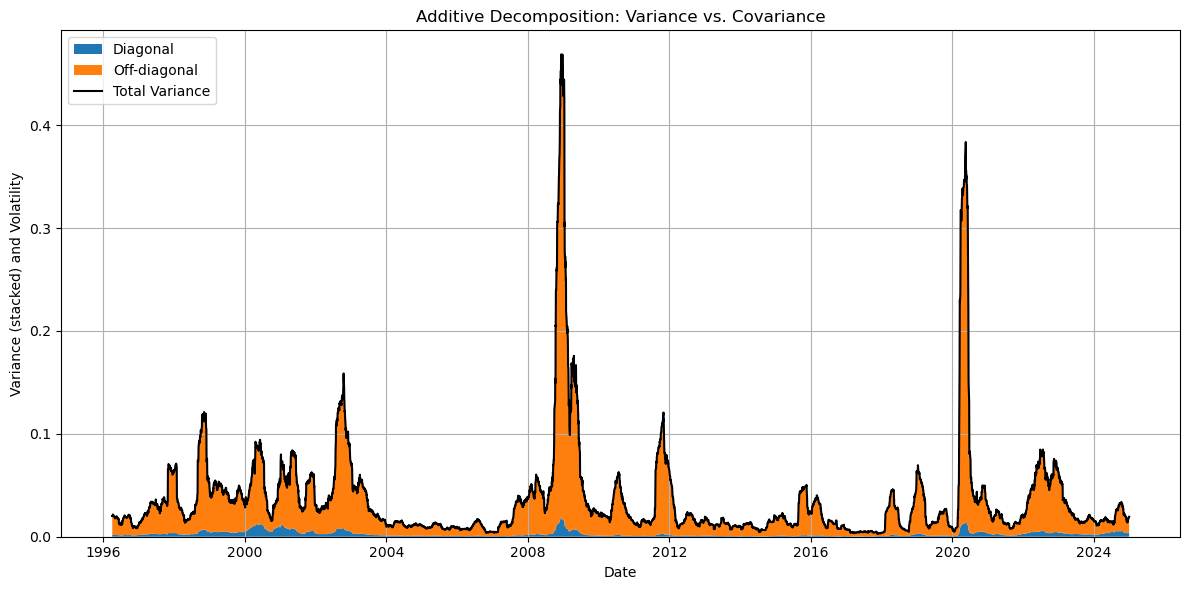

In [387]:
# Antag index_df har allerede dine vol-komponenter annualiseret:
v_var = index_df["vol_variance_component"] ** 2       # variance²
v_cov = index_df["vol_covariance_component"] ** 2     # covariance² (off-diagonal)

plt.figure(figsize=(12,6))
plt.stackplot(
    index_df["date"],
    v_var,
    v_cov,
    labels=["Diagonal", "Off-diagonal"],
    colors=["#1f77b4", "#ff7f0e"]
)
# Total volatilitet (σ) ovenpå:
plt.plot(
    index_df["date"],
    index_df["vol_total_reconstructed"]**2,
    color="black",
    label="Total Variance"
)

plt.title("Additive Decomposition: Variance vs. Covariance")
plt.xlabel("Date")
plt.ylabel("Variance (stacked) and Volatility")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


## plots of returns and vol of relicated vs actual index

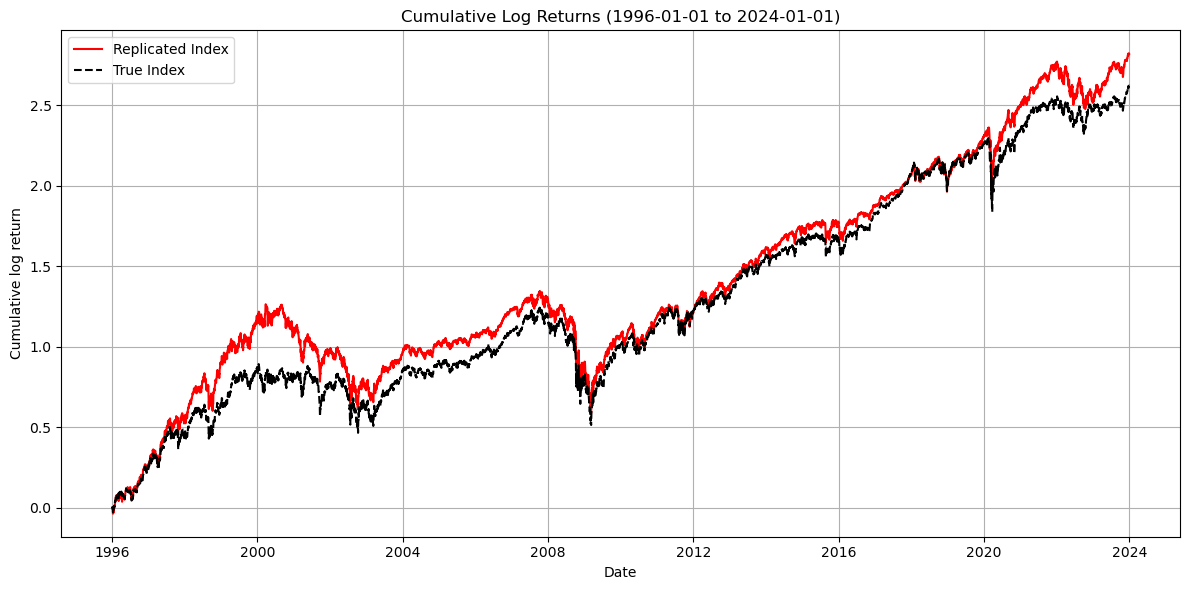

In [398]:
importlib.reload(cor_lib)
cor_lib.plot_log_cumulative_returns(index_daily_returns_df, "1996-01-01", "2024-01-01")


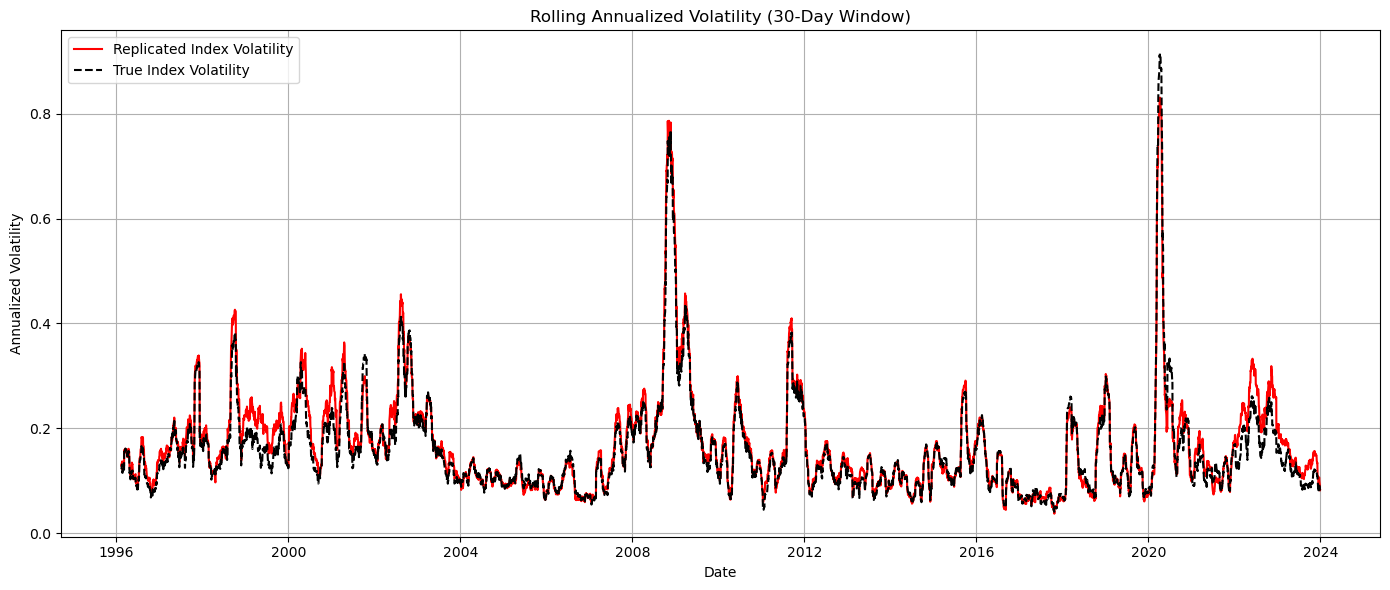

In [399]:
importlib.reload(cor_lib)
cor_lib.plot_rolling_volatility(index_daily_returns_df, "1996-01-01", "2024-01-01")


In [112]:
import pandas as pd
import numpy as np

def decompose_rolling_volatility(df, window=30):
    df = df.sort_values(["date", "ticker"]).copy()
    unique_dates = df["date"].sort_values().unique()[window-1:]
    output = []

    for current_date in unique_dates:
        window_dates = df["date"].sort_values().unique()
        window_start_idx = np.where(window_dates == current_date)[0][0] - window + 1
        window_range = window_dates[window_start_idx:window_start_idx + window]
        window_df = df[df["date"].isin(window_range)]

        return_matrix = window_df.pivot(index="date", columns="ticker", values="return")
        return_matrix = return_matrix.dropna(axis=1)

        weights_today = df[df["date"] == current_date]
        weights_today = weights_today[weights_today["ticker"].isin(return_matrix.columns)]
        weights_today = weights_today.set_index("ticker")["weight"]
        weights_today = weights_today.loc[return_matrix.columns]
        w = weights_today.values

        cov_matrix = return_matrix.cov().values

        diag_var = np.sum((w ** 2) * np.diag(cov_matrix))
        total_var = np.dot(w, np.dot(cov_matrix, w))
        off_diag_var = total_var - diag_var

        # Beregn annualiseret standardafvigelse
        diag_vol = np.sqrt(diag_var) * np.sqrt(252)
        off_diag_vol = np.sqrt(off_diag_var) * np.sqrt(252)
        total_vol = np.sqrt(total_var) * np.sqrt(252)

        output.append({
            "date": current_date,
            "volatility_diagonal": diag_vol,
            "volatility_off_diagonal": off_diag_vol,
            "volatility_total": total_vol
        })

    summary_df = pd.DataFrame(output)
    return summary_df
summary_df = decompose_rolling_volatility(daily_returns_constituents, window=30)


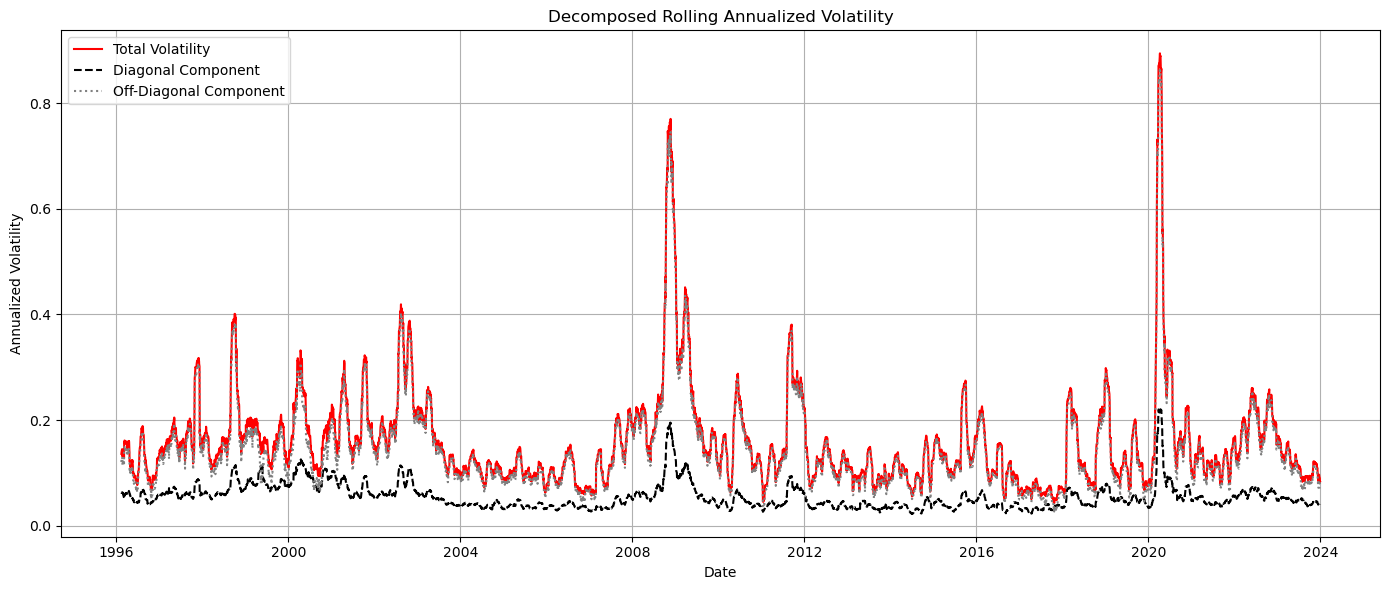

In [113]:
import matplotlib.pyplot as plt

def plot_decomposed_volatility(summary_df, start_date, end_date):
    # Filtrér perioden
    mask = (summary_df["date"] >= start_date) & (summary_df["date"] <= end_date)
    subset = summary_df.loc[mask].copy()

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(subset["date"], subset["volatility_total"], label="Total Volatility", color="red")
    plt.plot(subset["date"], subset["volatility_diagonal"], label="Diagonal Component", color="black", linestyle="--")
    plt.plot(subset["date"], subset["volatility_off_diagonal"], label="Off-Diagonal Component", color="gray", linestyle=":")

    plt.title("Decomposed Rolling Annualized Volatility")
    plt.xlabel("Date")
    plt.ylabel("Annualized Volatility")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_decomposed_volatility(summary_df, "1996-01-01", "2024-01-01")


# Section 3.A 

### figure 1 

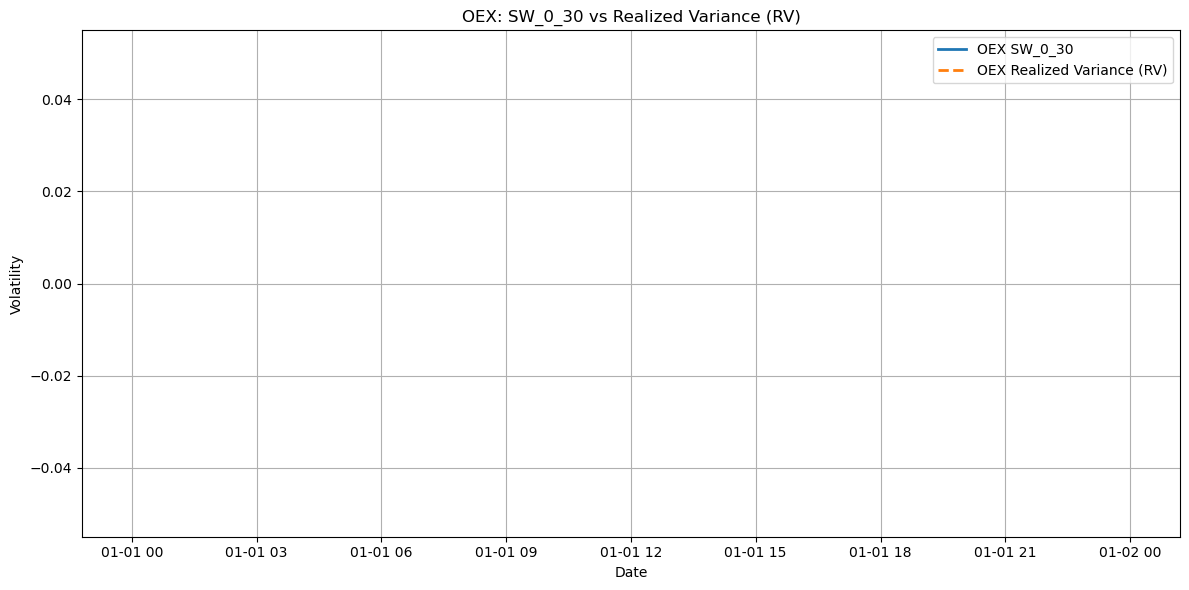

In [302]:
import matplotlib.pyplot as plt

# Filtrér for OEX
oex_data = sum_df[sum_df["ticker"] == "OEX"]

# Plot SW og Realized Variance (RV)
plt.figure(figsize=(12, 6))
plt.plot(oex_data["date"], oex_data["SW_0_30"], label="OEX SW_0_30", linewidth=2)
plt.plot(oex_data["date"], oex_data["RV"], label="OEX Realized Variance (RV)", linewidth=2, linestyle='--')
plt.title("OEX: SW_0_30 vs Realized Variance (RV)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### figure 2 initial 

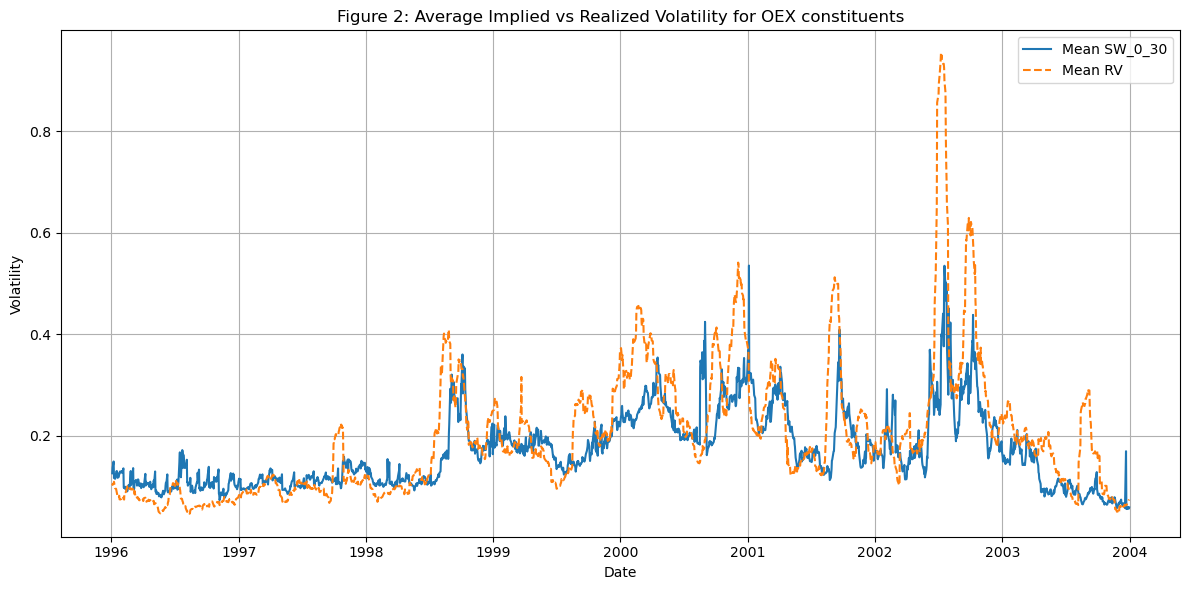

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Filtrér alle ikke-OEX tickers
non_oex = sum_df[sum_df["ticker"] != "OEX"]

# non_oex = sum_df[(sum_df["ticker"] != "RAL") & (sum_df["ticker"] != "HET")]

# Gruppér på dato og regn ligevægtet gennemsnit
avg_sw = non_oex.groupby("date")["SW_0_30"].mean()
avg_rv = non_oex.groupby("date")["RV"].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_sw.index, avg_sw.values, label="Mean SW_0_30")
plt.plot(avg_rv.index, avg_rv.values, label="Mean RV", linestyle="--")
plt.title("Figure 2: Average Implied vs Realized Volatility for OEX constituents")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


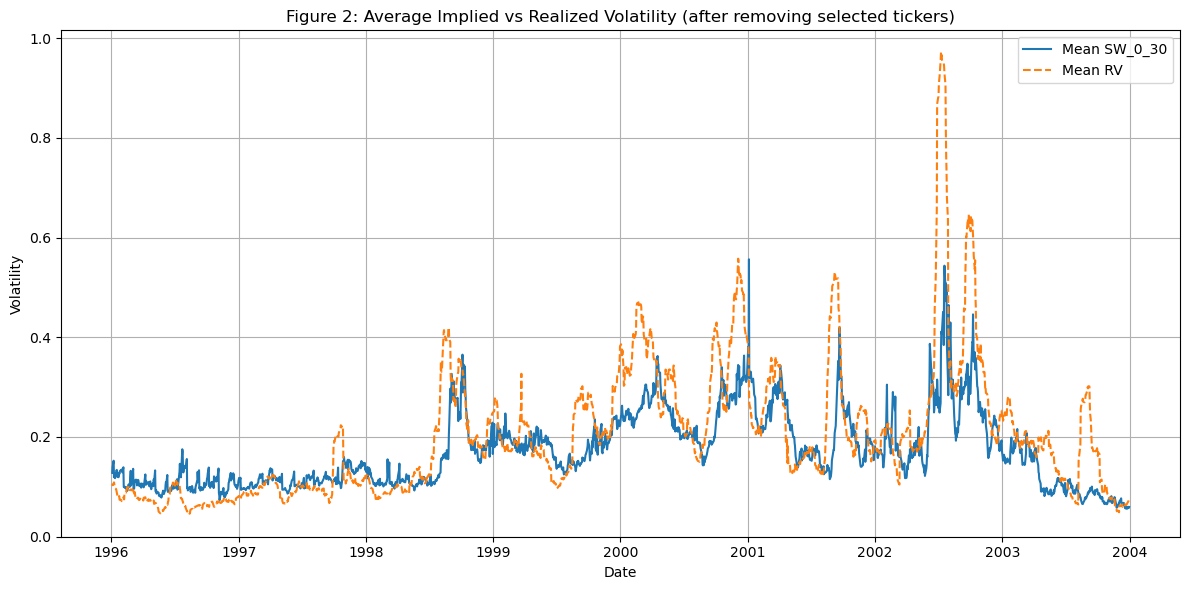

In [326]:
import pandas as pd
import matplotlib.pyplot as plt

# Liste over tickers du vil fjerne
tickers_to_remove = ["BAX", "MMM", "ATI", "PFE"]

# Filtrér: Fjern både "OEX" og dine uønskede tickers
filtered = sum_df[
    (sum_df["ticker"] != "OEX") &
    (~sum_df["ticker"].isin(tickers_to_remove))
]

# Gruppér på dato og regn ligevægtet gennemsnit
avg_sw = filtered.groupby("date")["SW_0_30"].mean()
avg_rv = filtered.groupby("date")["RV"].mean()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(avg_sw.index, avg_sw.values, label="Mean SW_0_30")
plt.plot(avg_rv.index, avg_rv.values, label="Mean RV", linestyle="--")
plt.title("Figure 2: Average Implied vs Realized Volatility (after removing selected tickers)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### investigating negative SW

In [304]:
# Find observationer med negativ SW_0_30
negatives = sum_df[sum_df["SW_0_30"] < 0]

# Find de unikke tickers
negative_tickers = negatives["ticker"].unique()

# Print som en flot streng (med " " rundt om hver ticker)
ticker_string = " ".join(negative_tickers)

print("Tickers med negative SW_0_30 værdier:\n")
print(ticker_string)


Tickers med negative SW_0_30 værdier:

IBM DIS SO


### merging SW and RV to return DF 

In [318]:
# Merge SW_0_30 fra sum_df over på final_df
final_df = final_df_constituents.merge(
    sum_df[["date", "ticker", "SW_0_30", "RV", "close"]],
    on=["date", "ticker"],
    how="left"
)

# (valgfrit) Tjek om der mangler noget
print(final_df.head(10))


        date ticker    weight    return  SW_0_30  RV  close
0 1996-01-03     AA  0.005556  0.016092      NaN NaN    NaN
1 1996-01-03    AEP  0.004431  0.000000      NaN NaN    NaN
2 1996-01-03    AIG  0.025526  0.006693      NaN NaN    NaN
3 1996-01-03   AMGN  0.008925 -0.010730      NaN NaN    NaN
4 1996-01-03    ATI  0.008106  0.008811      NaN NaN    NaN
5 1996-01-03    AVP  0.002964  0.011551      NaN NaN    NaN
6 1996-01-03    AXP  0.011592  0.005422      NaN NaN    NaN
7 1996-01-03     BA  0.015805 -0.009390      NaN NaN    NaN
8 1996-01-03    BAC  0.014215 -0.016886      NaN NaN    NaN
9 1996-01-03    BAX  0.006516  0.021021      NaN NaN    NaN


## investigatin EXTREME IV VALUES

### positive

In [327]:
# Sorter final_df efter 'SW_0_30' fra højest til lavest
top_swaps = final_df.sort_values(by="RV", ascending=False)

# Vis de 50 største værdier
print(top_swaps.head(50))


             date ticker        weight    return   SW_0_30         RV   close
142148 2002-07-19    WMB  7.819516e-04 -0.183544  2.453046  21.562797  5.1600
141608 2002-07-11    WMB  6.047176e-04  0.092338  2.112751  21.554616  5.5600
142058 2002-07-18    WMB  7.463452e-04  0.019355  2.215447  21.553133  6.3200
141968 2002-07-17    WMB  7.218853e-04  0.045531  2.223217  21.538260  6.2000
141428 2002-07-09    WMB  6.063229e-04 -0.055556  2.002543  21.524196  5.1000
141518 2002-07-10    WMB  5.859787e-04 -0.001961  1.967665  21.498877  5.0900
141878 2002-07-16    WMB  7.044312e-04  0.008503  2.206887  21.488219  5.9300
141698 2002-07-12    WMB  6.562351e-04  0.023381  2.106906  21.452301  5.6900
141788 2002-07-15    WMB  6.774577e-04  0.033392  2.352081  21.446344  5.8800
141338 2002-07-08    WMB  6.044818e-04 -0.009174       NaN  21.384654  5.4000
142238 2002-07-22    WMB  6.657423e-04 -0.610465       NaN  21.295204  2.0100
141248 2002-07-05    WMB  6.169992e-04  0.016791       NaN  20.1

### negative 

In [307]:
# naegtive SW
top_swaps = final_df.sort_values(by="SW_0_30", ascending=True)

# Vis de 50 største værdier
print(top_swaps.head(50))


             date ticker    weight    return   SW_0_30        RV  close
39799  1997-11-11    IBM  0.034006  0.013436 -0.168045  0.112415  99.00
39781  1997-11-11    DIS  0.020442  0.006584 -0.148372  0.086765  86.00
112138 2001-03-06     SO  0.003758 -0.005094 -0.027033  0.115427  31.25
174853 2003-12-26     PG  0.024247 -0.001017  0.016259  0.012532  98.24
174583 2003-12-22     PG  0.024109  0.006460  0.016495  0.009081  98.15
174313 2003-12-17     PG  0.024659 -0.002737  0.016750  0.012923  98.38
174223 2003-12-16     PG  0.024649  0.008485  0.017684  0.013472  98.65
174403 2003-12-18     PG  0.024563  0.009453  0.017992  0.012967  99.31
173136 2003-11-28     PG  0.024508  0.003755  0.018397  0.012395  96.24
172954 2003-11-25     PG  0.024755  0.002587  0.018594  0.012571  96.87
174493 2003-12-19     PG  0.024542 -0.018024  0.018647  0.012972  97.52
171407 2003-10-31     PG  0.025188  0.003676  0.018763  0.009771  98.29
172863 2003-11-24     PG  0.024895  0.008981  0.018810  0.013514

In [308]:
import pandas as pd
import numpy as np

def detect_conflict_pct_only_v5(df, forhold_threshold=2.0, diff_threshold=0.5):
    df = df.copy()
    df = df.sort_values(["ticker", "date", "exdate", "cp_flag", "moneyness", "mid"]).reset_index(drop=True)

    df["group_id"] = df.groupby(["ticker", "date", "exdate", "cp_flag"]).ngroup()

    df["prev_conflict_rate"] = 0.0
    df["next_conflict_rate"] = 0.0

    results = []

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        if n < 2:
            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)
        else:
            mids_matrix = np.tile(mids, (n, 1))

            if cp_flag == "C":
                prev_conflicts = (mids_matrix[:, :].T < mids).T
                next_conflicts = (mids_matrix[:, :].T > mids).T
            else:
                prev_conflicts = (mids_matrix[:, :].T > mids).T
                next_conflicts = (mids_matrix[:, :].T < mids).T

            np.fill_diagonal(prev_conflicts, False)
            np.fill_diagonal(next_conflicts, False)

            prev_rates = np.zeros(n)
            next_rates = np.zeros(n)

            for i in range(n):
                prev_rates[i] = prev_conflicts[i, :i].mean() if i > 0 else 0
                next_rates[i] = next_conflicts[i, (i+1):].mean() if i < n-1 else 0

        result = pd.DataFrame({
            "index": group.index,
            "prev_conflict_rate": prev_rates,
            "next_conflict_rate": next_rates
        })
        results.append(result)

    conflict_rates_df = pd.concat(results).set_index("index")
    df.loc[conflict_rates_df.index, ["prev_conflict_rate", "next_conflict_rate"]] = conflict_rates_df[["prev_conflict_rate", "next_conflict_rate"]]

    df["combined_conflict_rate"] = df["prev_conflict_rate"] + df["next_conflict_rate"]
    df["conflict_arb_flag"] = (df["combined_conflict_rate"] >= 0.75).astype(int)

    ### --- NY DEL: Beregn BIG_FLAG med forhold OG difference --- ###
    df["big_flag"] = 0

    for group_id, group in df.groupby("group_id", group_keys=False):
        mids = group["mid"].values
        cp_flag = group["cp_flag"].iloc[0]
        n = len(mids)

        for i in range(n):
            if group["conflict_arb_flag"].iloc[i] == 1:
                mid = mids[i]
                prev_mids = mids[:i]
                next_mids = mids[(i+1):]

                # Tjek prev
                if len(prev_mids) > 0:
                    prev_ratio = np.mean(mid / prev_mids)
                    prev_diff = np.mean(np.abs(mid - prev_mids))

                    if cp_flag == "C" and prev_ratio > forhold_threshold and prev_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1
                    if cp_flag == "P" and prev_ratio < 1/forhold_threshold and prev_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1

                # Tjek next
                if len(next_mids) > 0:
                    next_ratio = np.mean(mid / next_mids)
                    next_diff = np.mean(np.abs(mid - next_mids))

                    if cp_flag == "C" and next_ratio < 1/forhold_threshold and next_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1
                    if cp_flag == "P" and next_ratio > forhold_threshold and next_diff > diff_threshold:
                        df.loc[group.index[i], "big_flag"] = 1

    # Lav group summary
    group_summary = df.groupby(["ticker", "date", "exdate", "cp_flag"]).agg(
        n_options=("mid", "count"),
        has_conflict=("conflict_arb_flag", "max"),
        has_big_conflict=("big_flag", "max")
    ).reset_index()

    return df.drop(columns=["group_id"]), group_summary



import os

def run_conflict_detection_on_folder(folder_path):
    # Lister til at samle resultater
    full_results = []
    full_summary = []

    # Loop gennem alle filer
    for filename in os.listdir(folder_path):
        if 'od_rdy' in filename and filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            print(f"Processing {file_path}...")

            # Læs filen
            od_temp = pd.read_csv(file_path)

            # Forbehandling før konflikt detection
            od_temp["moneyness"] = np.log(od_temp["K"] / od_temp["F"])
            od_temp = od_temp.dropna(subset=["IV", "mid", "K", "F"])

            # Kør konflikt detection
            df_result, summary_result = detect_conflict_pct_only_v5(od_temp)

            # Saml resultater
            full_results.append(df_result)
            full_summary.append(summary_result)

    # Kombinér alle resultater
    if full_results:
        final_df = pd.concat(full_results, ignore_index=True)
    else:
        final_df = pd.DataFrame()

    if full_summary:
        final_summary = pd.concat(full_summary, ignore_index=True)
    else:
        final_summary = pd.DataFrame()

    return final_df, final_summary


In [ ]:
folder = r"C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5"

final_df_detection, final_summary_detection = run_conflict_detection_on_folder(folder)


Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_1996.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_1997.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_1998.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_1999.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_2000.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_2001.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_2002.csv...
Processing C:\Users\axell\Desktop\CBS\data\OptionMetrics\volpy data output\OEX_constituents_short5\t_od_rdy_2003.csv...


In [ ]:
import pandas as pd
import numpy as np

# Antag at final_df og final_summary allerede er klar fra tidligere

# Først: filtrér grupper der har konflikter
conflict_groups = final_summary_detection[final_summary_detection["has_big_conflict"] == 1]

# Træk et tilfældigt eksempel
example_group = conflict_groups.sample(1)  # Tilføj evt. random_state=42 hvis du vil reproducere

# Filtrer fra hele det samlede datasæt
example_data = final_df_detection[
    (final_df_detection["ticker"] == example_group["ticker"].values[0]) &
    (final_df_detection["date"] == example_group["date"].values[0]) &
    (final_df_detection["exdate"] == example_group["exdate"].values[0]) &
    (final_df_detection["cp_flag"] == example_group["cp_flag"].values[0])
]

# Udskriv relevante kolonner
example_data[["date", "ticker", "exdate", "cp_flag", "F", "K", "IV", "moneyness", "mid","prev_conflict_rate", "next_conflict_rate", "combined_conflict_rate", "conflict_arb_flag", "big_flag"]].head(40)


,date,ticker,exdate,cp_flag,F,K,IV,moneyness,mid,prev_conflict_rate,next_conflict_rate,combined_conflict_rate,conflict_arb_flag,big_flag
1212465,2003-09-25,MMM,2003-11-22,P,141.102291,60.0,3.537908,-0.855141,18.950,0.000000,1.0,1.000000,1,1
1212466,2003-09-25,MMM,2003-11-22,P,141.102291,120.0,0.273016,-0.161993,0.425,1.000000,0.0,1.000000,1,1
1212467,2003-09-25,MMM,2003-11-22,P,141.102291,125.0,0.253220,-0.121171,0.750,0.500000,0.0,0.500000,0,0
1212468,2003-09-25,MMM,2003-11-22,P,141.102291,130.0,0.232821,-0.081951,1.300,0.333333,0.0,0.333333,0,0
1212469,2003-09-25,MMM,2003-11-22,P,141.102291,135.0,0.217402,-0.044210,2.325,0.250000,0.0,0.250000,0,0
1212470,2003-09-25,MMM,2003-11-22,P,141.102291,140.0,0.205158,-0.007843,4.050,0.200000,0.0,0.200000,0,0


In [ ]:
# Gruppering på ticker-niveau
ticker_summary = final_summary_detection.groupby("ticker").agg(
    total_groups=("ticker", "count"),
    conflict_groups=("has_conflict", "sum"),
    big_conflict_groups=("has_big_conflict", "sum")
).reset_index()

# Sortér så vi ser tickere med flest big conflicts først
ticker_summary = ticker_summary.sort_values(by=["big_conflict_groups", "conflict_groups"], ascending=False)

# Udskriv de første 10
ticker_summary.head(10)


,ticker,total_groups,conflict_groups,big_conflict_groups
9,BAX,4755,10,10
40,MMM,7408,9,6
5,ATI,1316,13,2
48,PFE,7556,42,1
43,MS,6958,301,0
60,WFC,4542,174,0
55,TWX,6719,103,0
52,SLB,7295,62,0
30,IBM,8027,61,0
56,TXN,7844,59,0


## creating final summary df to plot over time 

In [328]:
# Fjern tickers du ikke vil have
tickers_to_remove = ["BAX", "MMM", "ATI", "PFE"]
final_df_remove_extreme = final_df[~final_df["ticker"].isin(tickers_to_remove)]

# Ligevægtet gennemsnit UDEN dropna
equal_weighted = (
    final_df_remove_extreme
    .groupby("date")
    .agg(
        SW_0_30_equalweight=("SW_0_30", "mean"),
        RV_equalweight=("RV", "mean")
    )
)

# Cap-weighted gennemsnit (skal stadig droppe NaN, ellers vægte gange NaN bliver skævt)
cap_weighted = (
    final_df_remove_extreme.dropna(subset=["SW_0_30", "RV"])
    .assign(
        weighted_sw=lambda x: x["SW_0_30"] * x["weight"],
        weighted_rv=lambda x: x["RV"] * x["weight"]
    )
    .groupby("date")
    .agg(
        SW_0_30_capweight=("weighted_sw", "sum"),
        RV_capweight=("weighted_rv", "sum")
    )
)

# Saml det hele
summary_df = pd.concat([equal_weighted, cap_weighted], axis=1)

# Se resultat
print(summary_df.head())


            SW_0_30_equalweight  RV_equalweight  SW_0_30_capweight  \
date                                                                 
1996-01-03                  NaN             NaN                NaN   
1996-01-04             0.130367        0.106884           0.040514   
1996-01-05             0.144463        0.104224           0.043005   
1996-01-08             0.153084        0.107024           0.047472   
1996-01-09             0.121260        0.110046           0.060140   

            RV_capweight  
date                      
1996-01-03           NaN  
1996-01-04      0.046583  
1996-01-05      0.046871  
1996-01-08      0.049671  
1996-01-09      0.063634  


In [340]:
import pandas as pd

# Parametre
tickers_to_remove = ["BAX", "MMM", "ATI", "PFE"]
n_select = 20  # fx vælg top 50 mest likvide tickere

# Fjern uønskede tickere
final_df_remove_extreme = final_df[~final_df["ticker"].isin(tickers_to_remove)]

# 1. Beregn NaN-ratio for hver ticker
nan_ratio = (
    final_df_remove_extreme
    .groupby("ticker")["SW_0_30"]
    .apply(lambda x: x.isna().mean())
)

# 2. Vælg top n_select tickere med lavest NaN-ratio
top_liquid_tickers = nan_ratio.sort_values().head(n_select).index.tolist()

# 3. Filtrér datasættet til kun de bedste tickere
final_df_liquid = final_df_remove_extreme[final_df_remove_extreme["ticker"].isin(top_liquid_tickers)]

# 4. Ligevægtet gennemsnit (uden dropna på hele rækker)
equal_weighted = (
    final_df_liquid
    .groupby("date")
    .agg(
        SW_0_30_equalweight=("SW_0_30", "mean"),
        RV_equalweight=("RV", "mean")
    )
)

# 5. Cap-weighted gennemsnit (her dropper vi stadig NaN's inden vægtning)
cap_weighted = (
    final_df_liquid.dropna(subset=["SW_0_30", "RV"])
    .assign(
        weighted_sw=lambda x: x["SW_0_30"] * x["weight"],
        weighted_rv=lambda x: x["RV"] * x["weight"]
    )
    .groupby("date")
    .agg(
        SW_0_30_capweight=("weighted_sw", "sum"),
        RV_capweight=("weighted_rv", "sum")
    )
)

# 6. Saml alt
summary_df = pd.concat([equal_weighted, cap_weighted], axis=1)

# 7. Se resultat
print(summary_df.head())


            SW_0_30_equalweight  RV_equalweight  SW_0_30_capweight  \
date                                                                 
1996-01-03                  NaN             NaN                NaN   
1996-01-04             0.172975        0.149063           0.018363   
1996-01-05             0.159824        0.143962           0.017185   
1996-01-08             0.175286        0.153089           0.018812   
1996-01-09             0.125296        0.158621           0.021699   

            RV_capweight  
date                      
1996-01-03           NaN  
1996-01-04      0.025735  
1996-01-05      0.025429  
1996-01-08      0.027325  
1996-01-09      0.031996  


### maybe clean if not enough active trade days 

In [236]:
# Hvilke tickere mangler oftest SW_0_30?
missing_sw = final_df[final_df["SW_0_30"].isna()]
print(missing_sw["ticker"].value_counts().head(10))


ticker
SO     7211
DOW    6841
DD     6296
F      6176
WFC    6160
T      6131
EXC    6120
GM     6105
RTN    6042
CL     5783
Name: count, dtype: int64


### plotting over time eq weighted and cap weighted

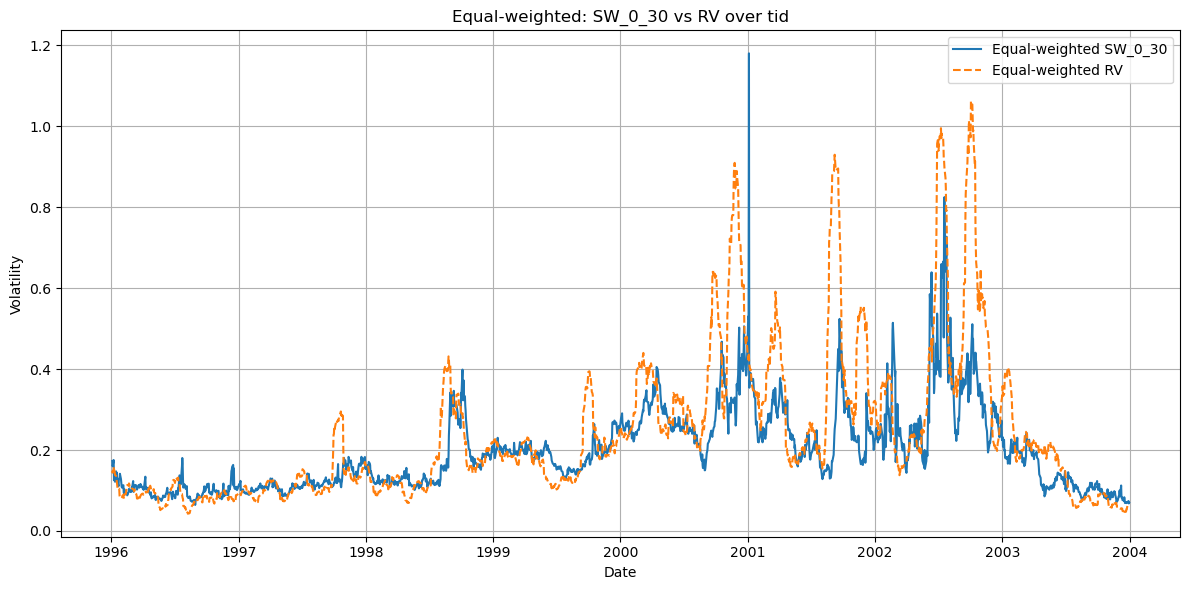

In [341]:
import matplotlib.pyplot as plt

# Plot Equal-weighted
plt.figure(figsize=(12, 6))
plt.plot(summary_df.index, summary_df["SW_0_30_equalweight"], label="Equal-weighted SW_0_30")
plt.plot(summary_df.index, summary_df["RV_equalweight"], label="Equal-weighted RV", linestyle="--")
plt.title("Equal-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


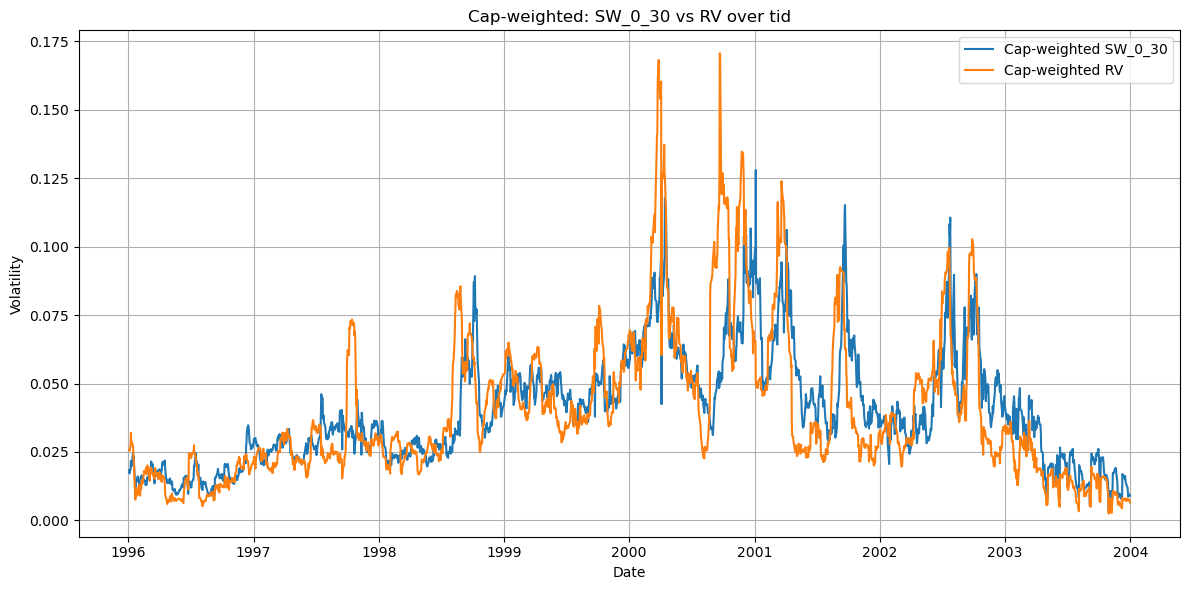

In [343]:
# Plot Cap-weighted
plt.figure(figsize=(12, 6))
plt.plot(summary_df.index, summary_df["SW_0_30_capweight"], label="Cap-weighted SW_0_30")
plt.plot(summary_df.index, summary_df["RV_capweight"], label="Cap-weighted RV", linestyle="-")
plt.title("Cap-weighted: SW_0_30 vs RV over tid")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### vrp average pr ticker

c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\axell\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


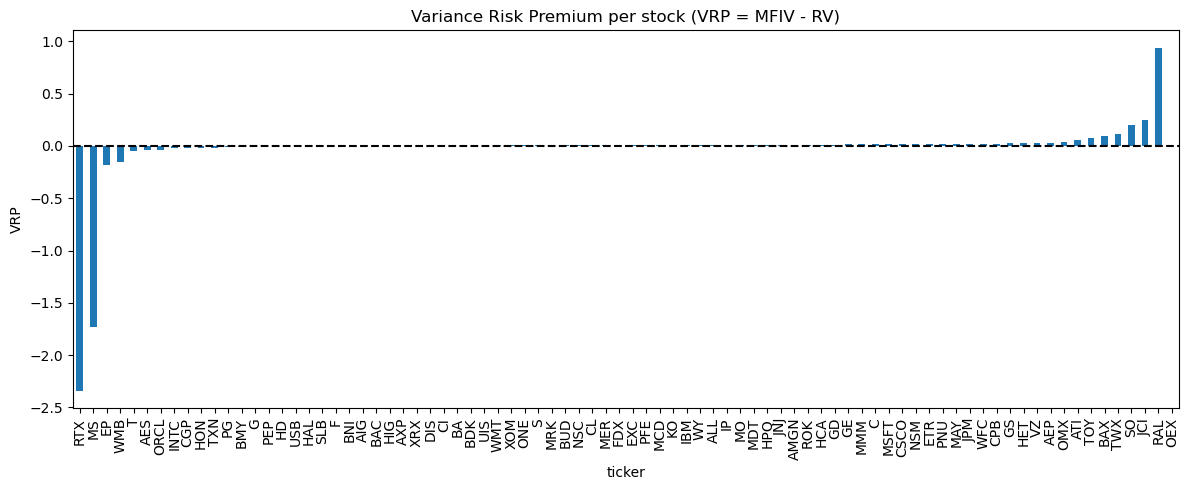

In [142]:
# Lav kopi med relevante kolonner
df_vrp = sum_df[["ticker", "date", "SW_0_30", "RV"]].copy()

# Beregn MFIV, VRP og log-ratio
df_vrp["MFIV"] = df_vrp["SW_0_30"]
df_vrp["VRP"] = df_vrp["MFIV"] - df_vrp["RV"]
df_vrp["log_RV_MFIV"] = np.log(df_vrp["RV"] / df_vrp["MFIV"])

# Gennemsnit pr. ticker
vrp_per_stock = df_vrp.groupby("ticker")[["VRP", "log_RV_MFIV"]].mean().sort_values("VRP")

# (Valgfrit) plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
vrp_per_stock["VRP"].plot(kind="bar")
plt.axhline(0, color="black", linestyle="--")
plt.title("Variance Risk Premium per stock (VRP = MFIV - RV)")
plt.ylabel("VRP")
plt.tight_layout()
plt.show()


### table 1 (data to table 1)

In [127]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Antag df_orpy eksisterer og har kolonnerne: 'ticker', 'date', 'SW_0_30', 'RV'
# 1. Beregn VRP
df_vrp = df_orpy.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# 2. T-test per ticker med Newey-West standard errors
result_rows = []

for ticker, group in df_vrp.groupby("ticker"):
    group = group.dropna(subset=["VRP"])

    if group.empty or len(group) < 30 or group["VRP"].isna().all():
        continue

    X = add_constant(pd.DataFrame(index=group.index))  
    y = group["VRP"].values

    model = OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 22})  # Newey-West standard errors

    t_stat = model.tvalues.iloc[0]
    p_value = model.pvalues.iloc[0]

    mean_vrp = group["VRP"].mean()

    result_rows.append({
        "ticker": ticker,
        "mean_vrp": mean_vrp,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_obs": len(group)
    })

# 3. Konstruér resultater som DataFrame og sorter
df_vrp_test = pd.DataFrame(result_rows)
df_vrp_test = df_vrp_test.sort_values("p_value").reset_index(drop=True)

# Print resultater
print(df_vrp_test)


   ticker  mean_vrp    t_stat       p_value  n_obs
0     OEX  0.015946  6.016974  1.777076e-09   2013
1     MMM  0.014239  2.927283  3.419371e-03   1859
2      GE  0.014030  2.782373  5.396301e-03   1903
3     LMT  0.021643  2.577821  9.942538e-03   1621
4      GD  0.013434  2.311066  2.082919e-02   1529
5    MSFT  0.018254  2.301221  2.137915e-02   1957
6     JNJ  0.011767  2.160623  3.072446e-02   1746
7     NKE  0.018112  1.802037  7.153955e-02   1950
8      KO  0.009739  1.791551  7.320498e-02   1700
9     MDT  0.010544  1.765097  7.754741e-02   1896
10    BAC  0.010366  1.733882  8.293899e-02   1913
11    FDX  0.008027  1.593861  1.109671e-01   1775
12    MCD  0.009355  1.560947  1.185362e-01   1519
13     MO  0.012245  1.486936  1.370317e-01   1945
14    PFE  0.009223  1.439905  1.498943e-01   1900
15   INTC -0.021750 -1.434489  1.514328e-01   1966
16    CAT  0.008303  1.409931  1.585600e-01   1768
17    IBM  0.009985  1.365284  1.721639e-01   2008
18      T  0.009779  1.340745  

### table 1

In [128]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

# Beregn VRP
df_vrp = df_orpy.copy()
df_vrp["VRP"] = df_vrp["SW_0_30"] - df_vrp["RV"]

# Split: OEX vs øvrige
df_oex = df_vrp[df_vrp["ticker"] == "OEX"].dropna(subset=["SW_0_30", "RV"])
df_ind = df_vrp[df_vrp["ticker"] != "OEX"].dropna(subset=["SW_0_30", "RV"])

# Gennemsnit
mean_rv_oex = df_oex["RV"].mean()
mean_sw_oex = df_oex["SW_0_30"].mean()
mean_rv_ind = df_ind["RV"].mean()
mean_sw_ind = df_ind["SW_0_30"].mean()

# sqrt forskelle
sqrt_diff_oex = np.sqrt(mean_rv_oex) - np.sqrt(mean_sw_oex)
sqrt_diff_ind = np.sqrt(mean_rv_ind) - np.sqrt(mean_sw_ind)

# OLS tests med Newey-West
X_oex = add_constant(np.ones(len(df_oex)))
y_oex = df_oex["VRP"]
model_oex = OLS(y_oex, X_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_oex = model_oex.pvalues.iloc[0]

ratios_oex = df_oex["RV"] / df_oex["SW_0_30"]
ratios_oex = ratios_oex.replace([np.inf, 0], np.nan).dropna()
Xr_oex = add_constant(np.ones(len(ratios_oex)))
model_ratio_oex = OLS(ratios_oex - 1, Xr_oex).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_oex = model_ratio_oex.pvalues.iloc[0]

X_ind = add_constant(np.ones(len(df_ind)))
y_ind = df_ind["VRP"]
model_ind = OLS(y_ind, X_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_vrp_eq_0_ind = model_ind.pvalues.iloc[0]

ratios_ind = df_ind["RV"] / df_ind["SW_0_30"]
ratios_ind = ratios_ind.replace([np.inf, 0], np.nan).dropna()
Xr_ind = add_constant(np.ones(len(ratios_ind)))
model_ratio_ind = OLS(ratios_ind - 1, Xr_ind).fit(cov_type="HAC", cov_kwds={"maxlags": 22})
p_ratio_eq_1_ind = model_ratio_ind.pvalues.iloc[0]

# Samlet tabel
summary_table = pd.DataFrame({
    "Category": [
        "Mean Realized Variance",
        "Mean Implied Variance (SW)",
        "Difference √RV − √SW",
        "p value for H₀: RV - SW = 0",
        "p value for H₀: RV / SW - 1 = 0"
    ],
    "Index Options (OEX)": [
        round(np.sqrt(mean_rv_oex), 6),
        round(np.sqrt(mean_sw_oex), 6),
        round(sqrt_diff_oex, 6),
        round(p_vrp_eq_0_oex, 6),
        round(p_ratio_eq_1_oex, 6)
    ],
    "Individual Options": [
        round(mean_rv_ind, 6),
        round(mean_sw_ind, 6),
        round(sqrt_diff_ind, 6),
        round(p_vrp_eq_0_ind, 6),
        round(p_ratio_eq_1_ind, 6)
    ]
})

# Udskriv tabel
print("\nSummary Table (SW terminologi):\n")
print(summary_table.to_string(index=False, col_space=35))


# Antag df_vrp_test eksisterer fra tidligere (output fra OLS tests per ticker)

# Filtrér kun individuelle aktier (dvs. ekskluder "OEX")
df_vrp_individuals = df_vrp_test[df_vrp_test["ticker"] != "OEX"]

# Antal pr kategori
summary_test_counts = pd.DataFrame({
    "Hypothesis": [
        "H₀: RV - SW = 0 not rejected",
        "H₀: RV - SW ≤ 0 rejected",
        "H₀: RV - SW ≥ 0 rejected"
    ],
    "# Ind. Stocks": [
        (df_vrp_individuals["p_value"] > 0.05).sum(),
        (df_vrp_individuals["t_stat"] > 0).sum(),
        (df_vrp_individuals["t_stat"] < 0).sum()
    ]
})

# Udskriv
print("\nIndividual Tests of Variance Risk Premia:\n")
print(summary_test_counts.to_string(index=False, col_space=40))





Summary Table (SW terminologi):

                           Category                 Index Options (OEX)                  Individual Options
             Mean Realized Variance                            0.208383                            0.152782
         Mean Implied Variance (SW)                            0.243659                            0.156450
               Difference √RV − √SW                           -0.035276                           -0.004664
        p value for H₀: RV - SW = 0                            0.000000                            0.000216
    p value for H₀: RV / SW - 1 = 0                            0.000000                            0.027315

Individual Tests of Variance Risk Premia:

                              Hypothesis                            # Ind. Stocks
            H₀: RV - SW = 0 not rejected                                       39
                H₀: RV - SW ≤ 0 rejected                                       32
                H₀: RV - SW 

# Section 3.B

In [129]:
sum_df['CF_30_SW_day'] = sum_df['CF_30_SW_day_v2']
sum_df["r_30_SW_day"] = sum_df["CF_30_SW_day"] / sum_df["SW_m1_29"].shift(1).rolling(window=21).mean()

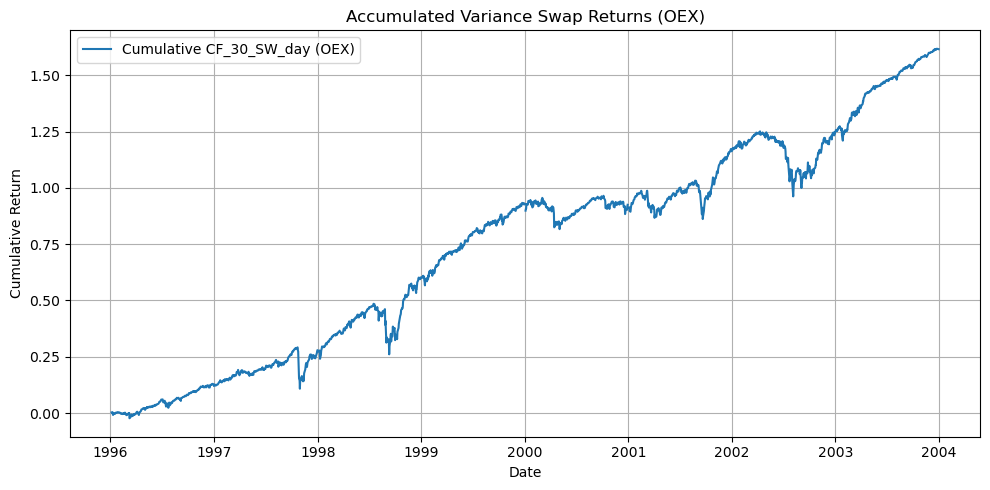

In [130]:
import matplotlib.pyplot as plt

# Filtrér for OEX
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()

# Sørg for sortering efter dato
oex_df = oex_df.sort_values("date")

# Beregn akkumuleret sum
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], label="Cumulative CF_30_SW_day (OEX)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Accumulated Variance Swap Returns (OEX)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [131]:
# Antag: sum_df har kolonnerne 'ticker', 'date', 'r_30_SW_day'
# Step 1: Fjern OEX og NA'er
vrp_data = sum_df[sum_df["ticker"] != "OEX"].copy()
vrp_data = vrp_data.dropna(subset=["r_30_SW_day"])

# Step 2: Beregn daglig VRP faktor som ligevægtet gennemsnit
vrp_factor = vrp_data.groupby("date")["r_30_SW_day"].mean().reset_index()
vrp_factor.rename(columns={"r_30_SW_day": "VRP_factor_eqw"}, inplace=True)

# Preview
print(vrp_factor.head())


        date  VRP_factor_eqw
0 1996-02-15       -0.130664
1 1996-03-06        0.025567
2 1996-03-07       -0.032031
3 1996-03-08        0.243584
4 1996-03-11       -0.028081


# Section 4.A trading strategy

### create rollnig correlation estimate

In [132]:
import pandas as pd
import numpy as np

sum_df_filtered = sum_df[sum_df['ticker'] != 'OEX'].copy()
sum_df_filtered.loc[:, 'date'] = pd.to_datetime(sum_df_filtered['date'])
pivot_df = sum_df_filtered.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

rolling_avg_corr = []
window = 30

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_corr = upper_triangle.stack().mean()
    rolling_avg_corr.append((pivot_df.index[i], avg_corr))

avg_corr_df = pd.DataFrame(rolling_avg_corr, columns=['date', 'avg_correlation'])


# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# plt.plot(avg_corr_df['date'], avg_corr_df['avg_correlation'])
# plt.title('30-dages gennemsnitlig korrelation over tid')
# plt.xlabel('Dato')
# plt.ylabel('Gennemsnitlig korrelation')
# plt.grid(True)
# plt.tight_layout()
# plt.show()



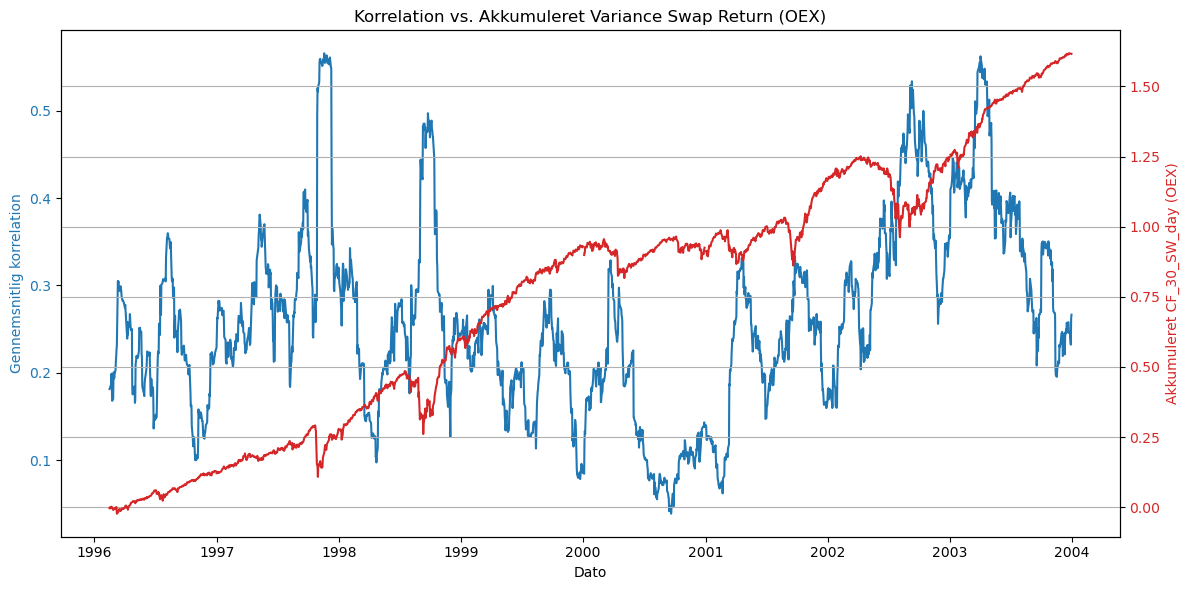

In [133]:
import matplotlib.pyplot as plt

# Filtrér for OEX og forbered data
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge OEX og korrelationer på dato
merged_df = pd.merge(avg_corr_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot med to akser
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig korrelation", color=color)
ax1.plot(merged_df["date"], merged_df["avg_correlation"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Korrelation vs. Akkumuleret Variance Swap Return (OEX)")
fig.tight_layout()
plt.grid(True)
plt.show()


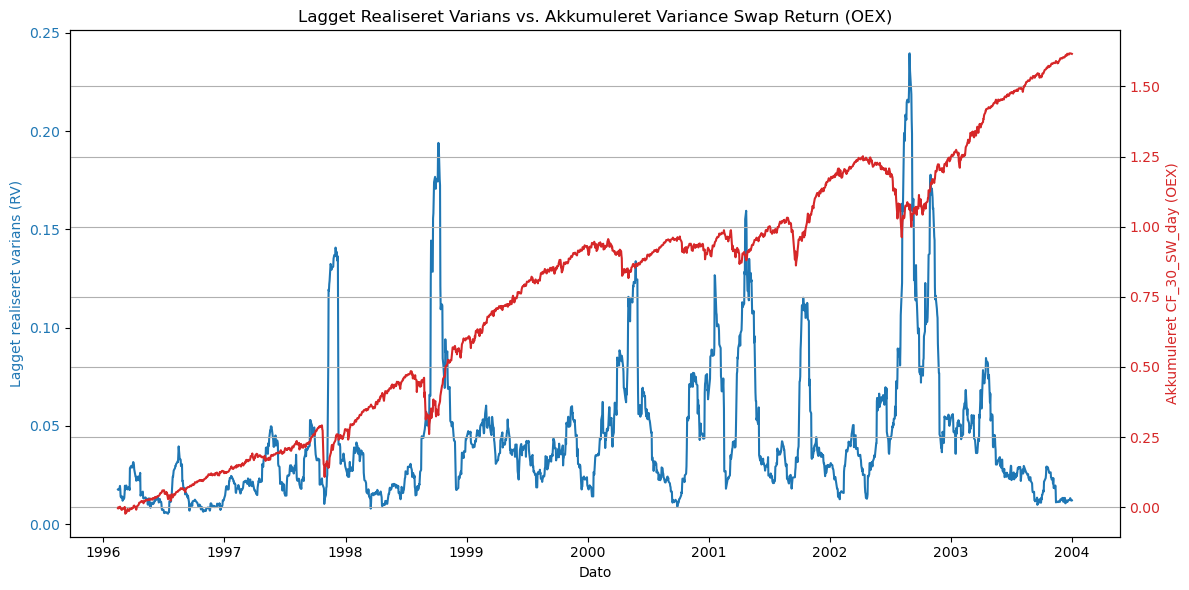

In [134]:
import matplotlib.pyplot as plt

# Filtrér for OEX og sorter
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")

# Lag realiseret varians 30 dage bagud
oex_df["RV_lagged"] = oex_df["RV"].shift(30)

# Beregn akkumuleret variance swap cashflow
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Drop NA (som kommer fra shift)
oex_df = oex_df.dropna(subset=["RV_lagged", "cum_CF_30_SW_day"])

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Lagget realiseret varians (RV)", color=color)
ax1.plot(oex_df["date"], oex_df["RV_lagged"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(oex_df["date"], oex_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Lagget Realiseret Varians vs. Akkumuleret Variance Swap Return (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


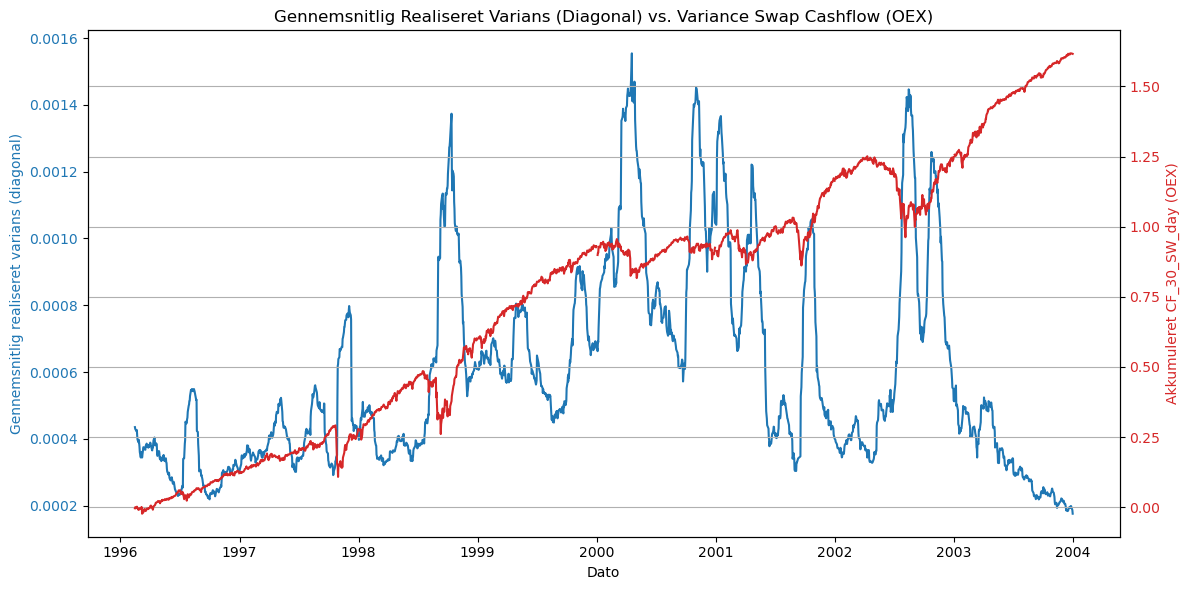

In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filtrer OEX fra
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])

# Pivotér til (dato × ticker) matrix
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Beregn rullende gennemsnitlig diagonal (varians)
window = 30
avg_diag_variance = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    diag_var = np.diag(cov_matrix)
    avg_var = np.nanmean(diag_var)
    avg_diag_variance.append((pivot_df.index[i], avg_var))

avg_var_df = pd.DataFrame(avg_diag_variance, columns=['date', 'avg_variance'])

# Forbered OEX cashflow
oex_df = sum_df[sum_df["ticker"] == "OEX"].copy()
oex_df = oex_df.sort_values("date")
oex_df["cum_CF_30_SW_day"] = -oex_df["CF_30_SW_day"].cumsum()

# Merge begge tidsserier
merged_df = pd.merge(avg_var_df, oex_df[["date", "cum_CF_30_SW_day"]], on="date", how="inner")

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_df["date"], merged_df["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel("Akkumuleret CF_30_SW_day (OEX)", color=color)
ax2.plot(merged_df["date"], merged_df["cum_CF_30_SW_day"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Gennemsnitlig Realiseret Varians (Diagonal) vs. Variance Swap Cashflow (OEX)")
plt.grid(True)
fig.tight_layout()
plt.show()


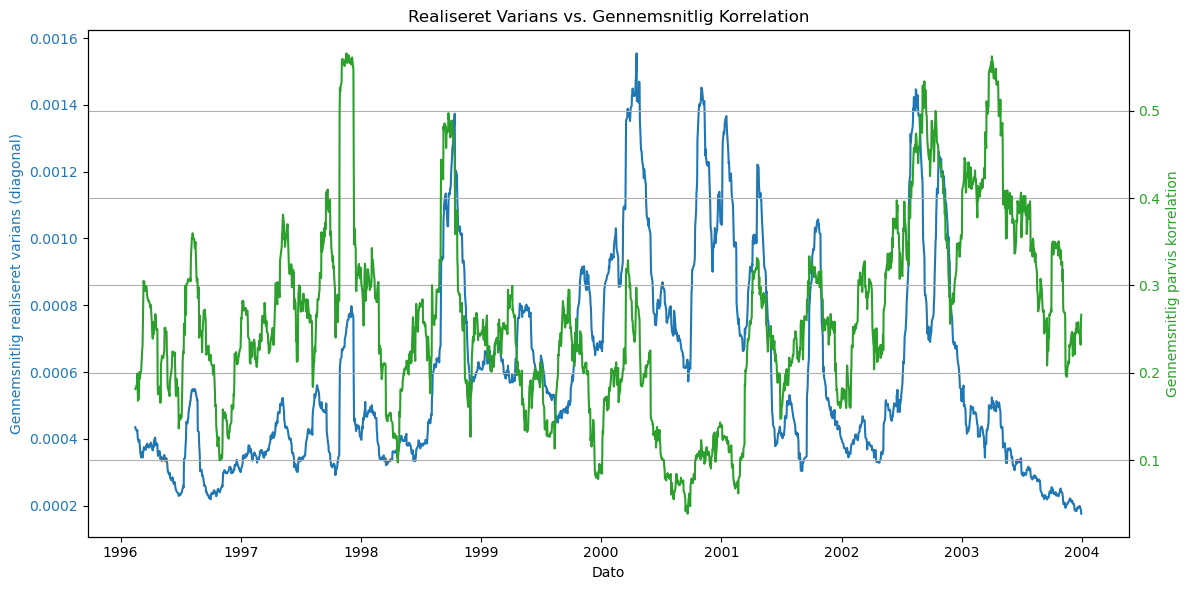

In [138]:
import matplotlib.pyplot as plt

# Merge realiseret varians og korrelation på dato
merged_metrics = pd.merge(avg_var_df, avg_corr_df, on='date', how='inner')

# Plot
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel("Dato")
ax1.set_ylabel("Gennemsnitlig realiseret varians (diagonal)", color=color)
ax1.plot(merged_metrics["date"], merged_metrics["avg_variance"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel("Gennemsnitlig parvis korrelation", color=color)
ax2.plot(merged_metrics["date"], merged_metrics["avg_correlation"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Realiseret Varians vs. Gennemsnitlig Korrelation")
plt.grid(True)
fig.tight_layout()
plt.show()


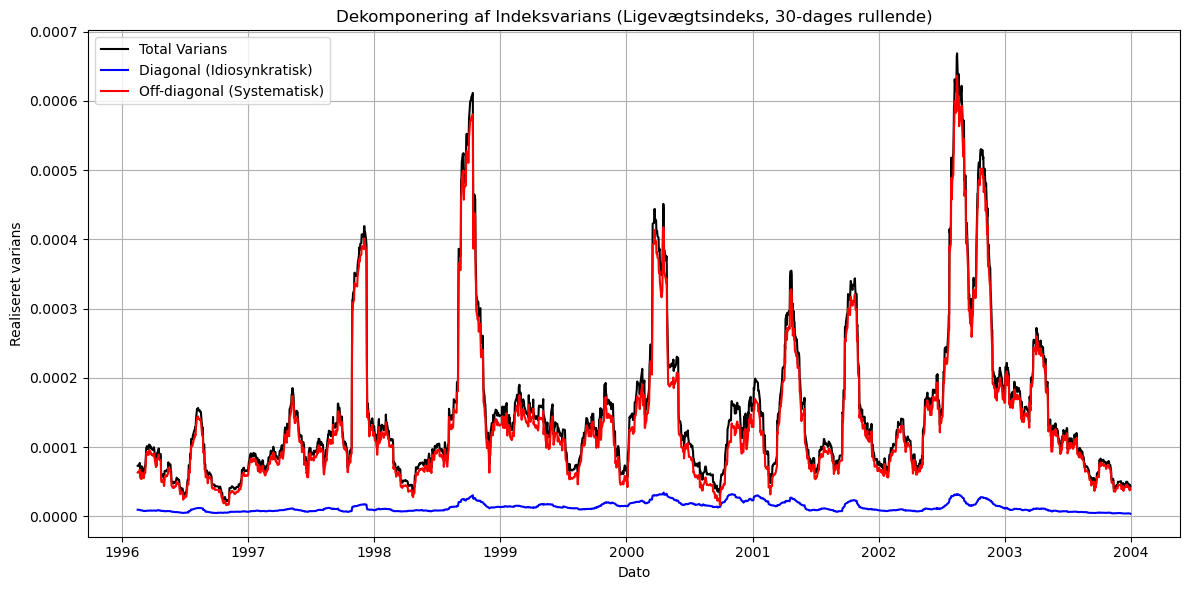

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Forbered data (ekskluder OEX)
returns_df = sum_df[sum_df["ticker"] != "OEX"].copy()
returns_df['date'] = pd.to_datetime(returns_df['date'])
pivot_df = returns_df.pivot(index='date', columns='ticker', values='return')
pivot_df = pivot_df.sort_index()

# Parametre
window = 30
decomp_data = []

# Loop over rullende vinduer
for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()
    
    # Antal aktier i dette vindue (kan variere lidt pga. NaNs)
    tickers_in_window = cov_matrix.columns
    N = len(tickers_in_window)
    if N < 2:
        continue  # skip hvis for få data

    # Ligevægtsvægte
    w = np.ones(N) / N
    w_matrix = np.outer(w, w)

    # Total indeksvarians
    total_variance = np.sum(w_matrix * cov_matrix.values)

    # Diagonalbidrag (idiosynkratisk)
    diag = np.diag(cov_matrix.values)
    diag_variance = np.sum((w ** 2) * diag)

    # Off-diagonalbidrag
    off_diag_variance = total_variance - diag_variance

    # Gem resultat
    decomp_data.append((pivot_df.index[i], total_variance, diag_variance, off_diag_variance))

# Konverter til DataFrame
decomp_df = pd.DataFrame(decomp_data, columns=["date", "total", "diagonal", "off_diagonal"])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(decomp_df["date"], decomp_df["total"], label="Total Varians", color="black")
plt.plot(decomp_df["date"], decomp_df["diagonal"], label="Diagonal (Idiosynkratisk)", color="blue")
plt.plot(decomp_df["date"], decomp_df["off_diagonal"], label="Off-diagonal (Systematisk)", color="red")
plt.title("Dekomponering af Indeksvarians (Ligevægtsindeks, 30-dages rullende)")
plt.xlabel("Dato")
plt.ylabel("Realiseret varians")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


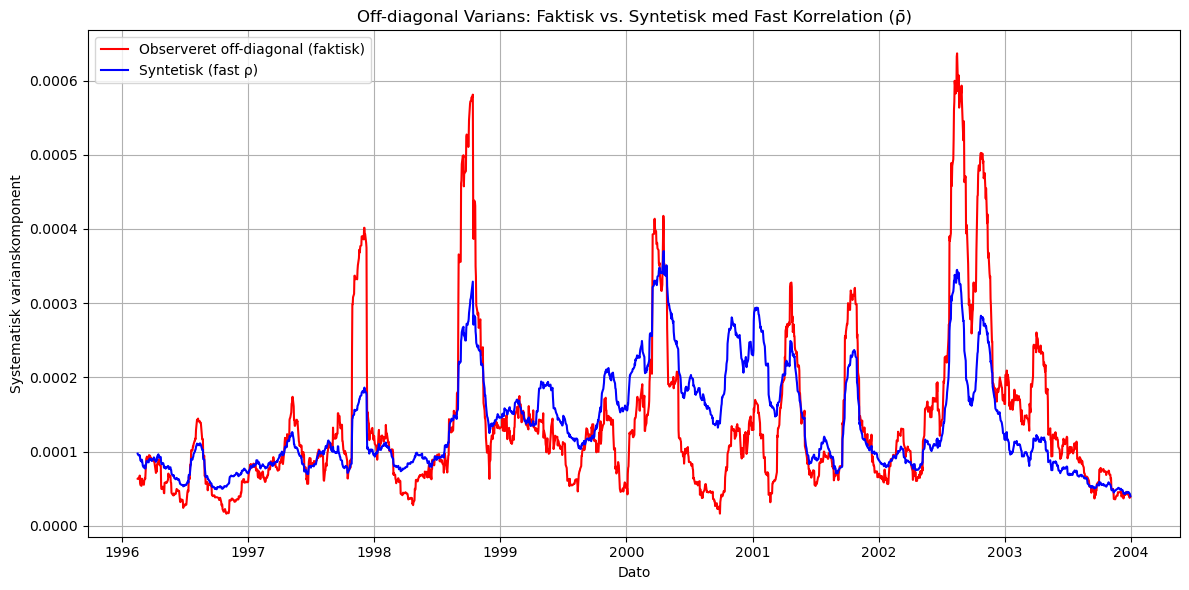

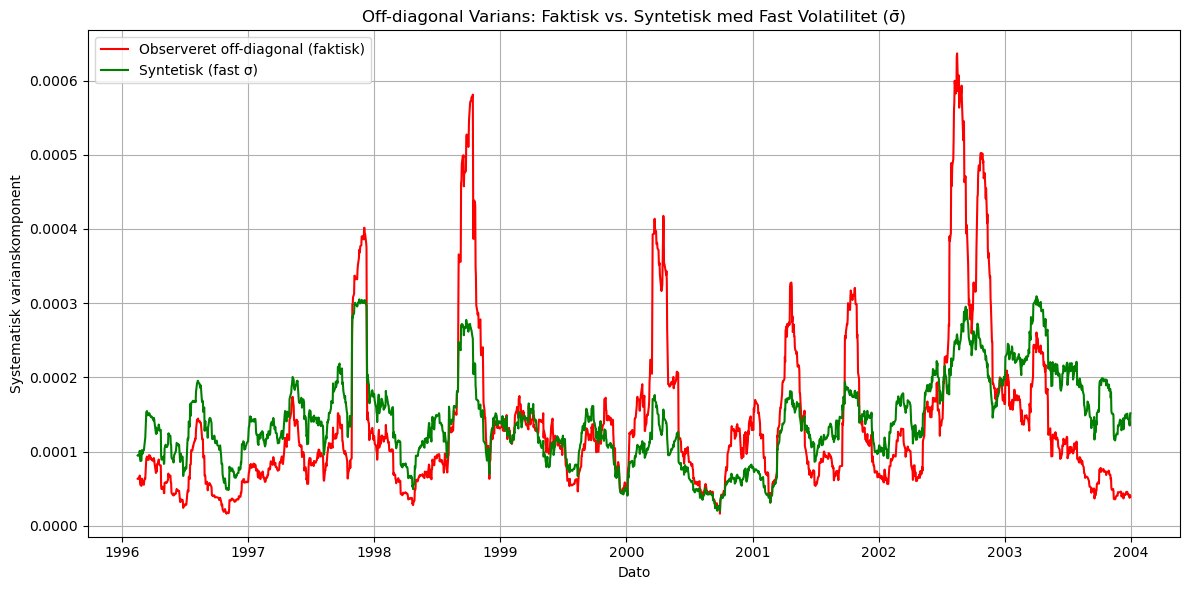

In [149]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast korrelation ---------
avg_rho = avg_corr_df["avg_correlation"].mean()
synthetic_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    cov_matrix = window_returns.cov()

    tickers = cov_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas = np.sqrt(np.diag(cov_matrix.values))
    rho_matrix = np.full((N, N), avg_rho)
    np.fill_diagonal(rho_matrix, 0)
    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_off_value = np.sum(weighted_synthetic_off)
    synthetic_off.append((pivot_df.index[i], synthetic_off_value))

synthetic_off_df = pd.DataFrame(synthetic_off, columns=["date", "synthetic_off"])
compare_df = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_off_df, on="date", how="inner")

if scale:
    scaling_factor = (compare_df["off_diagonal"] / compare_df["synthetic_off"]).mean()
    compare_df["synthetic_plot"] = compare_df["synthetic_off"] * scaling_factor
else:
    compare_df["synthetic_plot"] = compare_df["synthetic_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df["date"], compare_df["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df["date"], compare_df["synthetic_plot"], label="Syntetisk (fast ρ)", color="blue")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Korrelation (ρ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

# --------- Fast sigma ---------
long_cov = pivot_df.cov()
avg_sigmas = pd.Series(np.sqrt(np.diag(long_cov)), index=long_cov.columns)

rho_only_off = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    corr_matrix = window_returns.corr()

    tickers = corr_matrix.columns
    N = len(tickers)
    if N < 2:
        continue

    sigmas_window = avg_sigmas.loc[tickers].values
    sigma_outer = np.outer(sigmas_window, sigmas_window)
    rho_matrix = corr_matrix.values.copy()
    np.fill_diagonal(rho_matrix, 0)

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    synthetic_cov = rho_matrix * sigma_outer
    weighted_synthetic_off = synthetic_cov * w_matrix * off_diag_mask

    total_synthetic_off = np.sum(weighted_synthetic_off)
    rho_only_off.append((pivot_df.index[i], total_synthetic_off))

rho_only_df = pd.DataFrame(rho_only_off, columns=["date", "rho_only_off"])
compare_df_rho = pd.merge(decomp_df[["date", "off_diagonal"]], rho_only_df, on="date", how="inner")

if scale:
    scaling_rho = (compare_df_rho["off_diagonal"] / compare_df_rho["rho_only_off"]).mean()
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"] * scaling_rho
else:
    compare_df_rho["synthetic_plot"] = compare_df_rho["rho_only_off"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_rho["date"], compare_df_rho["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_rho["date"], compare_df_rho["synthetic_plot"], label="Syntetisk (fast σ)", color="green")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Volatilitet (σ̄)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


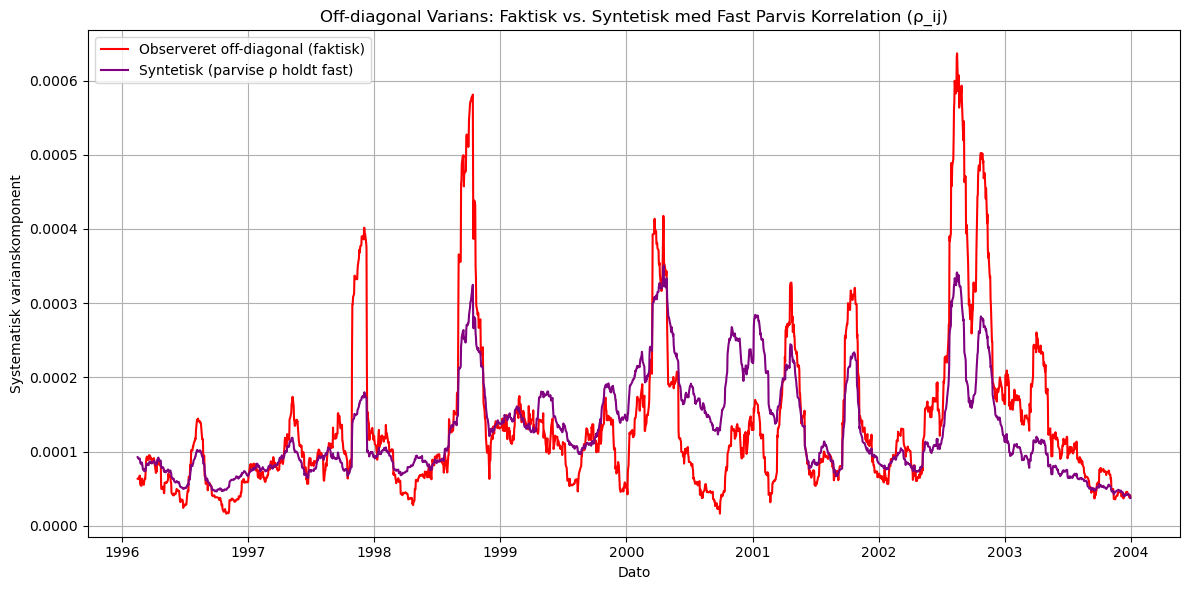

In [150]:
# Vælg om vi vil skalere syntetiske resultater
scale = False  # Sæt til True hvis du vil matche niveauer

# --------- Fast parvis korrelation (hele rho-matrix holdes fast) ---------

# Beregn gennemsnitlig korrelationsmatrix over hele perioden
full_corr = pivot_df.corr()
avg_corr_matrix = full_corr.values.copy()
np.fill_diagonal(avg_corr_matrix, 0)

synthetic_off_pairwise = []

for i in range(window, len(pivot_df)):
    window_returns = pivot_df.iloc[i - window:i]
    tickers = window_returns.columns
    N = len(tickers)
    if N < 2:
        continue

    cov_matrix = window_returns.cov()
    sigmas = np.sqrt(np.diag(cov_matrix.values))

    # Udtræk kun den relevante del af avg_corr_matrix for aktuelle tickers
    idx = [pivot_df.columns.get_loc(t) for t in tickers]
    rho_matrix = avg_corr_matrix[np.ix_(idx, idx)]

    sigma_outer = np.outer(sigmas, sigmas)
    synthetic_cov_off = rho_matrix * sigma_outer

    w = np.ones(N) / N
    w_matrix = np.outer(w, w)
    off_diag_mask = ~np.eye(N, dtype=bool)
    weighted_synthetic_off = synthetic_cov_off * w_matrix * off_diag_mask

    synthetic_value = np.sum(weighted_synthetic_off)
    synthetic_off_pairwise.append((pivot_df.index[i], synthetic_value))

synthetic_pairwise_df = pd.DataFrame(synthetic_off_pairwise, columns=["date", "synthetic_off_pairwise"])
compare_df_pairwise = pd.merge(decomp_df[["date", "off_diagonal"]], synthetic_pairwise_df, on="date", how="inner")

if scale:
    scaling_pairwise = (compare_df_pairwise["off_diagonal"] / compare_df_pairwise["synthetic_off_pairwise"]).mean()
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"] * scaling_pairwise
else:
    compare_df_pairwise["synthetic_plot"] = compare_df_pairwise["synthetic_off_pairwise"]

plt.figure(figsize=(12, 6))
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["off_diagonal"], label="Observeret off-diagonal (faktisk)", color="red")
plt.plot(compare_df_pairwise["date"], compare_df_pairwise["synthetic_plot"], label="Syntetisk (parvise ρ holdt fast)", color="purple")
plt.title("Off-diagonal Varians: Faktisk vs. Syntetisk med Fast Parvis Korrelation (ρ_ij)")
plt.xlabel("Dato")
plt.ylabel("Systematisk varianskomponent")
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


### trading strategy implement

In [ ]:
[ '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

# 0203524D = NSM
# NRTLQ = NT
# MTLQQ = GM
# LEHMQ = LEH
# NAN = NQN
# RSHCQ = RSH
# 987200Q = MAY
# 748957Q = PNU
# 653707Q = T
# 605555Q = S
# 3621240Q = ONE
# 3605818Q = HCA
# 3346Q = UBAN
# 2968900Q = IHRT
# 2258717D = EMC
# GBLXQ = GBLX
# ENRNQ = ENE
# EKDKQ = KODK
# DALRQ = DAL
# RTN/B = RTNB
# 1996074D = EP
# 3393199Q = BUD
# 1683997D = DELL
# 0848680D = FYBR
# 1255173D = WB
# 2071296D = NYX
# 1856613D = MON
# BRK/B = BRK
# 9903115D = CLB
# 1028411Q = G
# 1697067D = DOW
# 1715651D = DD
